In [1]:
# notebook: churn_rate_murphet_vs_prophet.ipynb  ────────────────
import os, warnings, time, pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error
from prophet import Prophet
import optuna
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf

# use all logical cores (but limit to 1 thread on very tiny fits)
os.environ["STAN_NUM_THREADS"] = str(os.cpu_count())
from murphet import fit_churn_model


/home/halsted/anaconda3/envs/murphet2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [13]:
SEED            = 42
TRIALS          = 50           # trials per model
INIT_MONTHS     = 18           # initial train window (≈ 1½ years)
CV_HORIZON      = 6            # months predicted per CV fold
CV_STEP         = 3            # slide step
HOLD_OUT_MO     = 6            # final test window
LB_LAGS         = 12

# ── metrics ------------------------------------------------------
rmse  = lambda a, f: np.sqrt(mean_squared_error(a, f))

smape = lambda a, f: 100 * np.mean(
    2 * np.abs(f - a) / (np.abs(a) + np.abs(f))
)

mape  = lambda a, f: 100 * np.mean(np.abs((a - f) / a))


In [14]:
from pathlib import Path
ROOT     = Path.cwd()                    # ← current working dir
CSV_PATH = ROOT / "data" / "Churn_Rate.csv"


df = (pd.read_csv(CSV_PATH, parse_dates=["ds"])
        .sort_values("ds")
        .reset_index(drop=True))

if not (0 < df["y"]).all() or not (df["y"] < 1).all():
    raise ValueError("This notebook assumes 0 < y < 1 (beta likelihood).")

df["t"] = np.arange(len(df))
t_all, y_all = df["t"].to_numpy(), df["y"].to_numpy()

first_test   = INIT_MONTHS
fold_starts  = list(range(first_test,
                          len(df) - HOLD_OUT_MO - CV_HORIZON + 1,
                          CV_STEP))
print(f"{len(df)} rows  →  {len(fold_starts)} CV folds")


51 rows  →  8 CV folds


In [15]:
def mur_cfg(trial):
    periods, harms = [12.0], [trial.suggest_int("harm_year", 1, 4)]
    # optional quarterly
    if trial.suggest_categorical("add_qtr", [0, 1]):
        periods.append(3.0)
        harms.append(trial.suggest_int("harm_qtr", 1, 3))

    return dict(
        periods           = periods,
        num_harmonics     = harms,
        n_changepoints    = trial.suggest_int("n_cp", 0, 5),
        delta_scale       = trial.suggest_float("delta", 0.005, 0.5, log=True),
        gamma_scale       = trial.suggest_float("gamma", 1.0, 15.0),
        season_scale      = trial.suggest_float("season_scale", 0.3, 3.0),
        likelihood        = "beta",
        inference         = "map",
        chains            = 2,
        iter              = 3000,
        warmup            = 0,
        seed              = SEED,
        threads_per_chain = 4
    )

def prop_cfg(trial):
    return dict(
        changepoint_prior_scale = trial.suggest_float("cp_scale", 0.01, 0.4, log=True),
        seasonality_prior_scale = trial.suggest_float("sea_scale", 0.1, 15, log=True),
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        interval_width=0.8,
    )


In [16]:
def cv_objective(make_cfg, is_murphet):
    def _obj(trial):
        cfg, errs = make_cfg(trial), []
        for idx in fold_starts:
            tr_end, te_end = idx, idx + CV_HORIZON
            try:
                if is_murphet:
                    mod  = fit_churn_model(t=t_all[:tr_end], y=y_all[:tr_end], **cfg)
                    pred = mod.predict(t_all[tr_end:te_end])
                else:
                    m = Prophet(**cfg)
                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore")
                        m.fit(df.iloc[:tr_end][["ds", "y"]])
                    fut  = m.make_future_dataframe(CV_HORIZON, freq="MS").iloc[-CV_HORIZON:]
                    pred = m.predict(fut)["yhat"].to_numpy()
                errs.append(rmse(y_all[tr_end:te_end], pred))
            except RuntimeError:
                return 1e6   # abort trial
        return float(np.mean(errs))
    return _obj


In [17]:
%%time
sampler = optuna.samplers.TPESampler(seed=SEED)

mur_study = optuna.create_study(direction="minimize", sampler=sampler)
mur_study.optimize(cv_objective(mur_cfg, True),
                   n_trials=TRIALS, show_progress_bar=True)

prop_study = optuna.create_study(direction="minimize", sampler=sampler)
prop_study.optimize(cv_objective(prop_cfg, False),
                    n_trials=TRIALS, show_progress_bar=True)

mur_cfg_best  = mur_cfg(mur_study.best_trial)
prop_cfg_best = prop_cfg(prop_study.best_trial)

print("\nBest CV RMSE")
print("Murphet :", mur_study.best_value)
print("Prophet :", prop_study.best_value)


[I 2025-04-19 21:40:56,905] A new study created in memory with name: no-name-9dda882b-b46b-461e-a39c-8c47de7b5315
  0%|          | 0/50 [00:00<?, ?it/s]21:40:56 - cmdstanpy - INFO - Chain [1] start processing
21:40:56 - cmdstanpy - INFO - Chain [1] done processing
21:40:56 - cmdstanpy - INFO - Chain [1] start processing
21:40:56 - cmdstanpy - INFO - Chain [1] done processing
21:40:56 - cmdstanpy - INFO - Chain [1] start processing
21:40:56 - cmdstanpy - INFO - Chain [1] done processing
21:40:56 - cmdstanpy - INFO - Chain [1] start processing
21:40:56 - cmdstanpy - INFO - Chain [1] done processing
21:40:56 - cmdstanpy - INFO - Chain [1] start processing
21:40:56 - cmdstanpy - INFO - Chain [1] done processing
21:40:56 - cmdstanpy - INFO - Chain [1] start processing
21:40:56 - cmdstanpy - INFO - Chain [1] done processing
21:40:56 - cmdstanpy - INFO - Chain [1] start processing
21:40:56 - cmdstanpy - INFO - Chain [1] done processing
21:40:56 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-04-19 21:40:56,956] Trial 0 finished with value: 0.23564915558917685 and parameters: {'harm_year': 2, 'add_qtr': 0, 'n_cp': 3, 'delta': 0.01025669131543725, 'gamma': 3.183923284706837, 'season_scale': 0.4568257528541385}. Best is trial 0 with value: 0.23564915558917685.


21:40:56 - cmdstanpy - INFO - Chain [1] done processing
21:40:56 - cmdstanpy - INFO - Chain [1] start processing
21:40:57 - cmdstanpy - INFO - Chain [1] done processing
21:40:57 - cmdstanpy - INFO - Chain [1] start processing
21:40:57 - cmdstanpy - INFO - Chain [1] done processing
21:40:57 - cmdstanpy - INFO - Chain [1] start processing
21:40:57 - cmdstanpy - INFO - Chain [1] done processing
21:40:57 - cmdstanpy - INFO - Chain [1] start processing
21:40:57 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 1. Best value: 0.0121214:   4%|▍         | 2/50 [00:00<00:03, 13.39it/s]21:40:57 - cmdstanpy - INFO - Chain [1] start processing
21:40:57 - cmdstanpy - INFO - Chain [1] done processing
21:40:57 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Best trial: 1. Best value: 0.0121214:   4%|▍         | 2/50 [00:00<00:03, 13.39it/s]21:40:57 - cmdstanpy - INFO - Chain [1] start processing
21:40:57 - cmdstanpy - INFO - Chain [1] done processing
21

[I 2025-04-19 21:40:57,055] Trial 1 finished with value: 0.012121366236950088 and parameters: {'harm_year': 4, 'add_qtr': 1, 'harm_qtr': 1, 'n_cp': 5, 'delta': 0.2311294500510414, 'gamma': 3.972747549495866, 'season_scale': 0.7909274114591717}. Best is trial 1 with value: 0.012121366236950088.
[I 2025-04-19 21:40:57,063] Trial 2 finished with value: 1000000.0 and parameters: {'harm_year': 1, 'add_qtr': 1, 'harm_qtr': 2, 'n_cp': 1, 'delta': 0.08369042894376064, 'gamma': 2.9529140491285855, 'season_scale': 1.088790551045089}. Best is trial 1 with value: 0.012121366236950088.


21:40:57 - cmdstanpy - INFO - Chain [1] done processing
21:40:57 - cmdstanpy - INFO - Chain [1] start processing
21:40:57 - cmdstanpy - INFO - Chain [1] done processing
21:40:57 - cmdstanpy - INFO - Chain [1] start processing
21:40:57 - cmdstanpy - INFO - Chain [1] done processing
21:40:57 - cmdstanpy - INFO - Chain [1] start processing
21:40:57 - cmdstanpy - INFO - Chain [1] done processing
21:40:57 - cmdstanpy - INFO - Chain [1] start processing
21:40:57 - cmdstanpy - INFO - Chain [1] done processing
21:40:57 - cmdstanpy - INFO - Chain [1] start processing
21:40:57 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 1. Best value: 0.0121214:   6%|▌         | 3/50 [00:00<00:03, 13.39it/s]21:40:57 - cmdstanpy - INFO - Chain [1] start processing
21:40:57 - cmdstanpy - INFO - Chain [1] done processing
21:40:57 - cmdstanpy - INFO - Chain [1] start processing
21:40:57 - cmdstanpy - INFO - Chain [1] done processing
21:40:57 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-04-19 21:40:57,142] Trial 3 finished with value: 0.014938468259570209 and parameters: {'harm_year': 2, 'add_qtr': 1, 'harm_qtr': 1, 'n_cp': 3, 'delta': 0.0765242606091573, 'gamma': 1.6503057780799681, 'season_scale': 1.9403711001338837}. Best is trial 1 with value: 0.012121366236950088.


21:40:57 - cmdstanpy - INFO - Chain [1] done processing
21:40:57 - cmdstanpy - INFO - Chain [1] start processing
21:40:57 - cmdstanpy - INFO - Chain [1] done processing
21:40:57 - cmdstanpy - INFO - Chain [1] start processing
21:40:57 - cmdstanpy - INFO - Chain [1] done processing
21:40:57 - cmdstanpy - INFO - Chain [1] start processing
21:40:57 - cmdstanpy - INFO - Chain [1] done processing
21:40:57 - cmdstanpy - INFO - Chain [1] start processing
21:40:57 - cmdstanpy - INFO - Chain [1] done processing
21:40:57 - cmdstanpy - INFO - Chain [1] start processing
21:40:57 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 1. Best value: 0.0121214:  10%|█         | 5/50 [00:00<00:02, 17.54it/s]21:40:57 - cmdstanpy - INFO - Chain [1] start processing
21:40:57 - cmdstanpy - INFO - Chain [1] done processing
21:40:57 - cmdstanpy - INFO - Chain [1] start processing
21:40:57 - cmdstanpy - INFO - Chain [1] done processing
21:40:57 - cmdstanpy - INFO - Chain [1] start processing
21:40:57 - c

[I 2025-04-19 21:40:57,201] Trial 4 finished with value: 0.04438689225614252 and parameters: {'harm_year': 1, 'add_qtr': 1, 'harm_qtr': 3, 'n_cp': 4, 'delta': 0.020332816567573974, 'gamma': 2.367409596089374, 'season_scale': 2.1474291715828238}. Best is trial 1 with value: 0.012121366236950088.
[I 2025-04-19 21:40:57,250] Trial 5 finished with value: 0.2653145661096486 and parameters: {'harm_year': 2, 'add_qtr': 1, 'harm_qtr': 1, 'n_cp': 5, 'delta': 0.01646379567211809, 'gamma': 10.275311980955747, 'season_scale': 1.1416199054414096}. Best is trial 1 with value: 0.012121366236950088.


21:40:57 - cmdstanpy - INFO - Chain [1] done processing
21:40:57 - cmdstanpy - INFO - Chain [1] start processing
21:40:57 - cmdstanpy - INFO - Chain [1] done processing
21:40:57 - cmdstanpy - INFO - Chain [1] start processing
21:40:57 - cmdstanpy - INFO - Chain [1] done processing
21:40:57 - cmdstanpy - INFO - Chain [1] start processing
21:40:57 - cmdstanpy - INFO - Chain [1] done processing
21:40:57 - cmdstanpy - INFO - Chain [1] start processing
21:40:57 - cmdstanpy - INFO - Chain [1] done processing
21:40:57 - cmdstanpy - INFO - Chain [1] start processing
21:40:57 - cmdstanpy - INFO - Chain [1] done processing
21:40:57 - cmdstanpy - INFO - Chain [1] start processing
21:40:57 - cmdstanpy - INFO - Chain [1] done processing
21:40:57 - cmdstanpy - INFO - Chain [1] start processing
21:40:57 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 1. Best value: 0.0121214:  14%|█▍        | 7/50 [00:00<00:02, 15.33it/s]21:40:57 - cmdstanpy - INFO - Chain [1] start processing
21:40:57 - c

[I 2025-04-19 21:40:57,357] Trial 6 finished with value: 0.012583403878476018 and parameters: {'harm_year': 3, 'add_qtr': 0, 'n_cp': 5, 'delta': 0.1775152429064153, 'gamma': 14.152985181898648, 'season_scale': 2.7160338461546516}. Best is trial 1 with value: 0.012121366236950088.
[I 2025-04-19 21:40:57,363] Trial 7 finished with value: 1000000.0 and parameters: {'harm_year': 3, 'add_qtr': 0, 'n_cp': 1, 'delta': 0.00615778586183301, 'gamma': 5.554624630685701, 'season_scale': 1.3494286821616015}. Best is trial 1 with value: 0.012121366236950088.
[I 2025-04-19 21:40:57,369] Trial 8 finished with value: 1000000.0 and parameters: {'harm_year': 2, 'add_qtr': 0, 'n_cp': 1, 'delta': 0.06086423540561215, 'gamma': 2.972939149646677, 'season_scale': 2.465931848035907}. Best is trial 1 with value: 0.012121366236950088.
[I 2025-04-19 21:40:57,374] Trial 9 finished with value: 1000000.0 and parameters: {'harm_year': 1, 'add_qtr': 0, 'n_cp': 1, 'delta': 0.005128781987092827, 'gamma': 12.416459998367

21:40:57 - cmdstanpy - INFO - Chain [1] done processing
21:40:57 - cmdstanpy - INFO - Chain [1] start processing
21:40:57 - cmdstanpy - INFO - Chain [1] done processing
21:40:57 - cmdstanpy - INFO - Chain [1] start processing
21:40:57 - cmdstanpy - INFO - Chain [1] done processing
21:40:57 - cmdstanpy - INFO - Chain [1] start processing
21:40:57 - cmdstanpy - INFO - Chain [1] done processing
21:40:57 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Best trial: 1. Best value: 0.0121214:  20%|██        | 10/50 [00:00<00:02, 15.33it/s]21:40:57 - cmdstanpy - INFO - Chain [1] start processing
21:40:57 - cmdstanpy - INFO - Chain [1] done processing
21:40:57 - cmdstanpy - INFO - Chain [1] start processing
21:40:57 - cmdstanpy - INFO - Chain [1] done processing
21:40:57 - cmdstanpy - INFO - Chain [1] start processing
21:40:57 - cmdstanpy - INFO - Chain [1] done processing
21:40:57 - cmdstanpy - INFO - Chain [1] start processing
21:40:57 - cmdstanpy - INFO 

[I 2025-04-19 21:40:57,437] Trial 10 finished with value: 1000000.0 and parameters: {'harm_year': 4, 'add_qtr': 1, 'harm_qtr': 1, 'n_cp': 4, 'delta': 0.46163367649564124, 'gamma': 6.914874901883871, 'season_scale': 0.34210595907783103}. Best is trial 1 with value: 0.012121366236950088.
[I 2025-04-19 21:40:57,538] Trial 11 finished with value: 0.011534643537649122 and parameters: {'harm_year': 4, 'add_qtr': 0, 'n_cp': 5, 'delta': 0.2611097757820336, 'gamma': 14.241336079631987, 'season_scale': 2.8717793160291896}. Best is trial 11 with value: 0.011534643537649122.


21:40:57 - cmdstanpy - INFO - Chain [1] done processing
21:40:57 - cmdstanpy - INFO - Chain [1] start processing
21:40:57 - cmdstanpy - INFO - Chain [1] done processing
21:40:57 - cmdstanpy - INFO - Chain [1] start processing
21:40:57 - cmdstanpy - INFO - Chain [1] done processing
21:40:57 - cmdstanpy - INFO - Chain [1] start processing
21:40:57 - cmdstanpy - INFO - Chain [1] done processing
21:40:57 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Best trial: 11. Best value: 0.0115346:  24%|██▍       | 12/50 [00:00<00:01, 20.71it/s]21:40:57 - cmdstanpy - INFO - Chain [1] start processing
21:40:57 - cmdstanpy - INFO - Chain [1] done processing
21:40:57 - cmdstanpy - INFO - Chain [1] start processing
21:40:57 - cmdstanpy - INFO - Chain [1] done processing
21:40:57 - cmdstanpy - INFO - Chain [1] start processing
21:40:57 - cmdstanpy - INFO - Chain [1] done processing
21:40:57 - cmdstanpy - INFO - Chain [1] start processing
21:40:57 - cmdstanpy - INFO

[I 2025-04-19 21:40:57,600] Trial 12 finished with value: 1000000.0 and parameters: {'harm_year': 4, 'add_qtr': 1, 'harm_qtr': 2, 'n_cp': 5, 'delta': 0.496248010511342, 'gamma': 8.833413698026428, 'season_scale': 2.862196416588653}. Best is trial 11 with value: 0.011534643537649122.


21:40:57 - cmdstanpy - INFO - Chain [1] start processing
21:40:57 - cmdstanpy - INFO - Chain [1] done processing
21:40:57 - cmdstanpy - INFO - Chain [1] start processing
21:40:57 - cmdstanpy - INFO - Chain [1] done processing
21:40:57 - cmdstanpy - INFO - Chain [1] start processing
21:40:57 - cmdstanpy - INFO - Chain [1] done processing
21:40:57 - cmdstanpy - INFO - Chain [1] start processing
21:40:57 - cmdstanpy - INFO - Chain [1] done processing
21:40:57 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Best trial: 11. Best value: 0.0115346:  26%|██▌       | 13/50 [00:00<00:01, 20.71it/s]21:40:57 - cmdstanpy - INFO - Chain [1] start processing
21:40:57 - cmdstanpy - INFO - Chain [1] done processing
21:40:57 - cmdstanpy - INFO - Chain [1] start processing
21:40:57 - cmdstanpy - INFO - Chain [1] done processing
21:40:57 - cmdstanpy - INFO - Chain [1] start processing
21:40:57 - cmdstanpy - INFO - Chain [1] done processing
21:40:57 - cmdstanpy - INFO

[I 2025-04-19 21:40:57,704] Trial 13 finished with value: 1000000.0 and parameters: {'harm_year': 4, 'add_qtr': 0, 'n_cp': 4, 'delta': 0.18963746315260874, 'gamma': 5.719673283522322, 'season_scale': 0.7453315657308015}. Best is trial 11 with value: 0.011534643537649122.
[I 2025-04-19 21:40:57,762] Trial 14 finished with value: 1000000.0 and parameters: {'harm_year': 3, 'add_qtr': 1, 'harm_qtr': 2, 'n_cp': 2, 'delta': 0.19898260168486398, 'gamma': 14.628600603098352, 'season_scale': 1.6416209903130483}. Best is trial 11 with value: 0.011534643537649122.


21:40:57 - cmdstanpy - INFO - Chain [1] done processing
21:40:57 - cmdstanpy - INFO - Chain [1] start processing
21:40:57 - cmdstanpy - INFO - Chain [1] done processing
21:40:57 - cmdstanpy - INFO - Chain [1] start processing
21:40:57 - cmdstanpy - INFO - Chain [1] done processing
21:40:57 - cmdstanpy - INFO - Chain [1] start processing
21:40:57 - cmdstanpy - INFO - Chain [1] done processing
21:40:57 - cmdstanpy - INFO - Chain [1] start processing
21:40:57 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 11. Best value: 0.0115346:  30%|███       | 15/50 [00:00<00:02, 17.50it/s]21:40:57 - cmdstanpy - INFO - Chain [1] start processing
21:40:57 - cmdstanpy - INFO - Chain [1] done processing
21:40:57 - cmdstanpy - INFO - Chain [1] start processing
21:40:57 - cmdstanpy - INFO - Chain [1] done processing
21:40:57 - cmdstanpy - INFO - Chain [1] start processing
21:40:57 - cmdstanpy - INFO - Chain [1] done processing
21:40:57 - cmdstanpy - INFO - Chain [1] start processing
21:40:57 -

[I 2025-04-19 21:40:57,858] Trial 15 finished with value: 0.011720817324128593 and parameters: {'harm_year': 4, 'add_qtr': 0, 'n_cp': 5, 'delta': 0.2750513639661741, 'gamma': 11.659029227577104, 'season_scale': 1.6311245164269392}. Best is trial 11 with value: 0.011534643537649122.


21:40:57 - cmdstanpy - INFO - Chain [1] done processing
21:40:57 - cmdstanpy - INFO - Chain [1] start processing
21:40:57 - cmdstanpy - INFO - Chain [1] done processing
21:40:57 - cmdstanpy - INFO - Chain [1] start processing
21:40:57 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 11. Best value: 0.0115346:  34%|███▍      | 17/50 [00:01<00:02, 15.91it/s]21:40:57 - cmdstanpy - INFO - Chain [1] start processing
21:40:57 - cmdstanpy - INFO - Chain [1] done processing
21:40:57 - cmdstanpy - INFO - Chain [1] start processing
21:40:57 - cmdstanpy - INFO - Chain [1] done processing
21:40:57 - cmdstanpy - INFO - Chain [1] start processing
21:40:57 - cmdstanpy - INFO - Chain [1] done processing
21:40:57 - cmdstanpy - INFO - Chain [1] start processing
21:40:57 - cmdstanpy - INFO - Chain [1] done processing
21:40:57 - cmdstanpy - INFO - Chain [1] start processing
21:40:57 - cmdstanpy - INFO - Chain [1] done processing
21:40:57 - cmdstanpy - INFO - Chain [1] start processing
21:40:57 -

[I 2025-04-19 21:40:57,924] Trial 16 finished with value: 0.012958376614002162 and parameters: {'harm_year': 3, 'add_qtr': 0, 'n_cp': 0, 'delta': 0.03383632884331449, 'gamma': 12.05951963943866, 'season_scale': 1.6996733075227355}. Best is trial 11 with value: 0.011534643537649122.
[I 2025-04-19 21:40:58,021] Trial 17 finished with value: 0.013211223908098941 and parameters: {'harm_year': 4, 'add_qtr': 0, 'n_cp': 4, 'delta': 0.12553794493657774, 'gamma': 12.385438916613925, 'season_scale': 2.3985282282846736}. Best is trial 11 with value: 0.011534643537649122.


21:40:58 - cmdstanpy - INFO - Chain [1] done processing
21:40:58 - cmdstanpy - INFO - Chain [1] start processing
21:40:58 - cmdstanpy - INFO - Chain [1] done processing
21:40:58 - cmdstanpy - INFO - Chain [1] start processing
21:40:58 - cmdstanpy - INFO - Chain [1] done processing
21:40:58 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Best trial: 11. Best value: 0.0115346:  38%|███▊      | 19/50 [00:01<00:02, 14.90it/s]21:40:58 - cmdstanpy - INFO - Chain [1] start processing
21:40:58 - cmdstanpy - INFO - Chain [1] done processing
21:40:58 - cmdstanpy - INFO - Chain [1] start processing
21:40:58 - cmdstanpy - INFO - Chain [1] done processing
21:40:58 - cmdstanpy - INFO - Chain [1] start processing
21:40:58 - cmdstanpy - INFO - Chain [1] done processing
21:40:58 - cmdstanpy - INFO - Chain [1] start processing
21:40:58 - cmdstanpy - INFO - Chain [1] done processing
21:40:58 - cmdstanpy - INFO - Chain [1] start processing
21:40:58 - cmdstanpy - INFO

[I 2025-04-19 21:40:58,083] Trial 18 finished with value: 1000000.0 and parameters: {'harm_year': 4, 'add_qtr': 0, 'n_cp': 3, 'delta': 0.3233857748383561, 'gamma': 9.9971964199443, 'season_scale': 1.6087325879748244}. Best is trial 11 with value: 0.011534643537649122.


21:40:58 - cmdstanpy - INFO - Chain [1] done processing
21:40:58 - cmdstanpy - INFO - Chain [1] start processing
21:40:58 - cmdstanpy - INFO - Chain [1] done processing
21:40:58 - cmdstanpy - INFO - Chain [1] start processing
21:40:58 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 11. Best value: 0.0115346:  38%|███▊      | 19/50 [00:01<00:02, 14.90it/s]21:40:58 - cmdstanpy - INFO - Chain [1] start processing
21:40:58 - cmdstanpy - INFO - Chain [1] done processing
21:40:58 - cmdstanpy - INFO - Chain [1] start processing
21:40:58 - cmdstanpy - INFO - Chain [1] done processing
21:40:58 - cmdstanpy - INFO - Chain [1] start processing
21:40:58 - cmdstanpy - INFO - Chain [1] done processing
21:40:58 - cmdstanpy - INFO - Chain [1] start processing
21:40:58 - cmdstanpy - INFO - Chain [1] done processing
21:40:58 - cmdstanpy - INFO - Chain [1] start processing
21:40:58 - cmdstanpy - INFO - Chain [1] done processing
21:40:58 - cmdstanpy - ERROR - Chain [1] error: error during proces

[I 2025-04-19 21:40:58,153] Trial 19 finished with value: 0.014105417186927382 and parameters: {'harm_year': 3, 'add_qtr': 0, 'n_cp': 5, 'delta': 0.11627607483296735, 'gamma': 13.587752555080776, 'season_scale': 1.9235947075437163}. Best is trial 11 with value: 0.011534643537649122.
[I 2025-04-19 21:40:58,204] Trial 20 finished with value: 1000000.0 and parameters: {'harm_year': 4, 'add_qtr': 0, 'n_cp': 2, 'delta': 0.319231807541222, 'gamma': 10.655441952964743, 'season_scale': 2.9661928080562836}. Best is trial 11 with value: 0.011534643537649122.
[I 2025-04-19 21:40:58,264] Trial 21 finished with value: 1000000.0 and parameters: {'harm_year': 4, 'add_qtr': 1, 'harm_qtr': 3, 'n_cp': 5, 'delta': 0.3348711547134805, 'gamma': 4.768152322493383, 'season_scale': 0.7241719224630409}. Best is trial 11 with value: 0.011534643537649122.


21:40:58 - cmdstanpy - INFO - Chain [1] done processing
21:40:58 - cmdstanpy - INFO - Chain [1] start processing
21:40:58 - cmdstanpy - INFO - Chain [1] done processing
21:40:58 - cmdstanpy - INFO - Chain [1] start processing
21:40:58 - cmdstanpy - INFO - Chain [1] done processing
21:40:58 - cmdstanpy - INFO - Chain [1] start processing
21:40:58 - cmdstanpy - INFO - Chain [1] done processing
21:40:58 - cmdstanpy - INFO - Chain [1] start processing
21:40:58 - cmdstanpy - INFO - Chain [1] done processing
21:40:58 - cmdstanpy - INFO - Chain [1] start processing
21:40:58 - cmdstanpy - INFO - Chain [1] done processing
21:40:58 - cmdstanpy - INFO - Chain [1] start processing
21:40:58 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 11. Best value: 0.0115346:  46%|████▌     | 23/50 [00:01<00:01, 14.81it/s]

[I 2025-04-19 21:40:58,350] Trial 22 finished with value: 0.013857549111151363 and parameters: {'harm_year': 4, 'add_qtr': 0, 'n_cp': 4, 'delta': 0.13238262936903913, 'gamma': 7.8731726032870615, 'season_scale': 1.1612198122856985}. Best is trial 11 with value: 0.011534643537649122.


21:40:58 - cmdstanpy - INFO - Chain [1] start processing
21:40:58 - cmdstanpy - INFO - Chain [1] done processing
21:40:58 - cmdstanpy - INFO - Chain [1] start processing
21:40:58 - cmdstanpy - INFO - Chain [1] done processing
21:40:58 - cmdstanpy - INFO - Chain [1] start processing
21:40:58 - cmdstanpy - INFO - Chain [1] done processing
21:40:58 - cmdstanpy - INFO - Chain [1] start processing
21:40:58 - cmdstanpy - INFO - Chain [1] done processing
21:40:58 - cmdstanpy - INFO - Chain [1] start processing
21:40:58 - cmdstanpy - INFO - Chain [1] done processing
21:40:58 - cmdstanpy - INFO - Chain [1] start processing
21:40:58 - cmdstanpy - INFO - Chain [1] done processing
21:40:58 - cmdstanpy - INFO - Chain [1] start processing
21:40:58 - cmdstanpy - INFO - Chain [1] done processing
21:40:58 - cmdstanpy - INFO - Chain [1] start processing
21:40:58 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 11. Best value: 0.0115346:  46%|████▌     | 23/50 [00:01<00:01, 14.81it/s]21:40:58 -

[I 2025-04-19 21:40:58,462] Trial 23 finished with value: 0.011965726449925926 and parameters: {'harm_year': 3, 'add_qtr': 1, 'harm_qtr': 1, 'n_cp': 5, 'delta': 0.23873095843308978, 'gamma': 13.208190188746075, 'season_scale': 0.8604070641215271}. Best is trial 11 with value: 0.011534643537649122.
[I 2025-04-19 21:40:58,526] Trial 24 finished with value: 0.021907032110525138 and parameters: {'harm_year': 3, 'add_qtr': 0, 'n_cp': 4, 'delta': 0.040681222448063166, 'gamma': 13.199128715288351, 'season_scale': 1.391255636437639}. Best is trial 11 with value: 0.011534643537649122.


21:40:58 - cmdstanpy - INFO - Chain [1] done processing
21:40:58 - cmdstanpy - INFO - Chain [1] start processing
21:40:58 - cmdstanpy - INFO - Chain [1] done processing
21:40:58 - cmdstanpy - INFO - Chain [1] start processing
21:40:58 - cmdstanpy - INFO - Chain [1] done processing
21:40:58 - cmdstanpy - INFO - Chain [1] start processing
21:40:58 - cmdstanpy - INFO - Chain [1] done processing
21:40:58 - cmdstanpy - INFO - Chain [1] start processing
21:40:58 - cmdstanpy - INFO - Chain [1] done processing
21:40:58 - cmdstanpy - INFO - Chain [1] start processing
21:40:58 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 11. Best value: 0.0115346:  50%|█████     | 25/50 [00:01<00:01, 13.65it/s]21:40:58 - cmdstanpy - INFO - Chain [1] start processing
21:40:58 - cmdstanpy - INFO - Chain [1] done processing
21:40:58 - cmdstanpy - INFO - Chain [1] start processing
21:40:58 - cmdstanpy - INFO - Chain [1] done processing
21:40:58 - cmdstanpy - INFO - Chain [1] start processing
21:40:58 -

[I 2025-04-19 21:40:58,620] Trial 25 finished with value: 0.0116559794520374 and parameters: {'harm_year': 3, 'add_qtr': 0, 'n_cp': 5, 'delta': 0.2512753923709464, 'gamma': 11.254756839507152, 'season_scale': 0.9560239157951338}. Best is trial 11 with value: 0.011534643537649122.


21:40:58 - cmdstanpy - INFO - Chain [1] start processing
21:40:58 - cmdstanpy - INFO - Chain [1] done processing
21:40:58 - cmdstanpy - INFO - Chain [1] start processing
21:40:58 - cmdstanpy - INFO - Chain [1] done processing
21:40:58 - cmdstanpy - INFO - Chain [1] start processing
21:40:58 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 11. Best value: 0.0115346:  54%|█████▍    | 27/50 [00:01<00:01, 13.04it/s]21:40:58 - cmdstanpy - INFO - Chain [1] start processing
21:40:58 - cmdstanpy - INFO - Chain [1] done processing
21:40:58 - cmdstanpy - INFO - Chain [1] start processing
21:40:58 - cmdstanpy - INFO - Chain [1] done processing
21:40:58 - cmdstanpy - INFO - Chain [1] start processing
21:40:58 - cmdstanpy - INFO - Chain [1] done processing
21:40:58 - cmdstanpy - INFO - Chain [1] start processing
21:40:58 - cmdstanpy - INFO - Chain [1] done processing
21:40:58 - cmdstanpy - INFO - Chain [1] start processing
21:40:58 - cmdstanpy - INFO - Chain [1] done processing
21:40:58 -

[I 2025-04-19 21:40:58,696] Trial 26 finished with value: 0.01445074699048644 and parameters: {'harm_year': 3, 'add_qtr': 0, 'n_cp': 4, 'delta': 0.09103856052899795, 'gamma': 11.260998135527895, 'season_scale': 2.6089316921424683}. Best is trial 11 with value: 0.011534643537649122.
[I 2025-04-19 21:40:58,756] Trial 27 finished with value: 1000000.0 and parameters: {'harm_year': 4, 'add_qtr': 0, 'n_cp': 5, 'delta': 0.3708864077675992, 'gamma': 14.852457577449607, 'season_scale': 1.419361688725649}. Best is trial 11 with value: 0.011534643537649122.


21:40:58 - cmdstanpy - INFO - Chain [1] done processing
21:40:58 - cmdstanpy - INFO - Chain [1] start processing
21:40:58 - cmdstanpy - INFO - Chain [1] done processing
21:40:58 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Best trial: 11. Best value: 0.0115346:  58%|█████▊    | 29/50 [00:01<00:01, 13.00it/s]21:40:58 - cmdstanpy - INFO - Chain [1] start processing
21:40:58 - cmdstanpy - INFO - Chain [1] done processing
21:40:58 - cmdstanpy - INFO - Chain [1] start processing
21:40:58 - cmdstanpy - INFO - Chain [1] done processing
21:40:58 - cmdstanpy - INFO - Chain [1] start processing
21:40:58 - cmdstanpy - INFO - Chain [1] done processing
21:40:58 - cmdstanpy - INFO - Chain [1] start processing
21:40:58 - cmdstanpy - INFO - Chain [1] done processing
21:40:58 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-04-19 21:40:58,851] Trial 28 finished with value: 1000000.0 and parameters: {'harm_year': 4, 'add_qtr': 0, 'n_cp': 3, 'delta': 0.2656221930432764, 'gamma': 9.086280531541734, 'season_scale': 1.8586203468621463}. Best is trial 11 with value: 0.011534643537649122.


21:40:58 - cmdstanpy - INFO - Chain [1] done processing
21:40:58 - cmdstanpy - INFO - Chain [1] start processing
21:40:58 - cmdstanpy - INFO - Chain [1] done processing
21:40:58 - cmdstanpy - INFO - Chain [1] start processing
21:40:58 - cmdstanpy - INFO - Chain [1] done processing
21:40:58 - cmdstanpy - INFO - Chain [1] start processing
21:40:58 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 11. Best value: 0.0115346:  58%|█████▊    | 29/50 [00:02<00:01, 13.00it/s]21:40:58 - cmdstanpy - INFO - Chain [1] start processing
21:40:58 - cmdstanpy - INFO - Chain [1] done processing
21:40:58 - cmdstanpy - INFO - Chain [1] start processing
21:40:58 - cmdstanpy - INFO - Chain [1] done processing
21:40:58 - cmdstanpy - INFO - Chain [1] start processing
21:40:58 - cmdstanpy - INFO - Chain [1] done processing
21:40:58 - cmdstanpy - INFO - Chain [1] start processing
21:40:58 - cmdstanpy - INFO - Chain [1] done processing
21:40:58 - cmdstanpy - INFO - Chain [1] start processing
21:40:58 -

[I 2025-04-19 21:40:58,952] Trial 29 finished with value: 0.013495569504478076 and parameters: {'harm_year': 2, 'add_qtr': 0, 'n_cp': 5, 'delta': 0.14954442797233866, 'gamma': 11.577191027548249, 'season_scale': 0.5082118577208503}. Best is trial 11 with value: 0.011534643537649122.
[I 2025-04-19 21:40:59,029] Trial 30 finished with value: 0.0133397847879089 and parameters: {'harm_year': 3, 'add_qtr': 0, 'n_cp': 4, 'delta': 0.10059646101057251, 'gamma': 9.797929650420441, 'season_scale': 2.160324402056284}. Best is trial 11 with value: 0.011534643537649122.


21:40:59 - cmdstanpy - INFO - Chain [1] done processing
21:40:59 - cmdstanpy - INFO - Chain [1] start processing
21:40:59 - cmdstanpy - INFO - Chain [1] done processing
21:40:59 - cmdstanpy - INFO - Chain [1] start processing
21:40:59 - cmdstanpy - INFO - Chain [1] done processing
21:40:59 - cmdstanpy - INFO - Chain [1] start processing
21:40:59 - cmdstanpy - INFO - Chain [1] done processing
21:40:59 - cmdstanpy - INFO - Chain [1] start processing
21:40:59 - cmdstanpy - INFO - Chain [1] done processing
21:40:59 - cmdstanpy - INFO - Chain [1] start processing
21:40:59 - cmdstanpy - INFO - Chain [1] done processing
21:40:59 - cmdstanpy - INFO - Chain [1] start processing
21:40:59 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 31. Best value: 0.011426:  62%|██████▏   | 31/50 [00:02<00:01, 12.44it/s] 21:40:59 - cmdstanpy - INFO - Chain [1] start processing
21:40:59 - cmdstanpy - INFO - Chain [1] done processing
21:40:59 - cmdstanpy - INFO - Chain [1] start processing
21:40:59 -

[I 2025-04-19 21:40:59,183] Trial 31 finished with value: 0.011426040356596714 and parameters: {'harm_year': 3, 'add_qtr': 0, 'n_cp': 5, 'delta': 0.26239545531925296, 'gamma': 13.104714538458683, 'season_scale': 0.9597668285562206}. Best is trial 31 with value: 0.011426040356596714.
[I 2025-04-19 21:40:59,288] Trial 32 finished with value: 0.011774946569091924 and parameters: {'harm_year': 3, 'add_qtr': 0, 'n_cp': 5, 'delta': 0.24855402525290846, 'gamma': 12.961093743228842, 'season_scale': 0.5237777878010885}. Best is trial 31 with value: 0.011426040356596714.
[I 2025-04-19 21:40:59,336] Trial 33 finished with value: 1000000.0 and parameters: {'harm_year': 2, 'add_qtr': 0, 'n_cp': 5, 'delta': 0.4127569155207895, 'gamma': 14.07672474284087, 'season_scale': 0.9372792282215979}. Best is trial 31 with value: 0.011426040356596714.


21:40:59 - cmdstanpy - INFO - Chain [1] done processing
21:40:59 - cmdstanpy - INFO - Chain [1] start processing
21:40:59 - cmdstanpy - INFO - Chain [1] done processing
21:40:59 - cmdstanpy - INFO - Chain [1] start processing
21:40:59 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 31. Best value: 0.011426:  70%|███████   | 35/50 [00:02<00:01, 11.50it/s]21:40:59 - cmdstanpy - INFO - Chain [1] start processing
21:40:59 - cmdstanpy - INFO - Chain [1] done processing
21:40:59 - cmdstanpy - INFO - Chain [1] start processing
21:40:59 - cmdstanpy - INFO - Chain [1] done processing
21:40:59 - cmdstanpy - INFO - Chain [1] start processing
21:40:59 - cmdstanpy - INFO - Chain [1] done processing
21:40:59 - cmdstanpy - INFO - Chain [1] start processing
21:40:59 - cmdstanpy - INFO - Chain [1] done processing
21:40:59 - cmdstanpy - INFO - Chain [1] start processing
21:40:59 - cmdstanpy - INFO - Chain [1] done processing
21:40:59 - cmdstanpy - INFO - Chain [1] start processing
21:40:59 - 

[I 2025-04-19 21:40:59,424] Trial 34 finished with value: 0.012920022274321208 and parameters: {'harm_year': 3, 'add_qtr': 0, 'n_cp': 5, 'delta': 0.18201666104504893, 'gamma': 11.016768246981268, 'season_scale': 0.941592918299006}. Best is trial 31 with value: 0.011426040356596714.
[I 2025-04-19 21:40:59,497] Trial 35 finished with value: 0.015936161492525035 and parameters: {'harm_year': 4, 'add_qtr': 0, 'n_cp': 4, 'delta': 0.0696944152202119, 'gamma': 11.769150981271656, 'season_scale': 1.3024021663240668}. Best is trial 31 with value: 0.011426040356596714.
[I 2025-04-19 21:40:59,574] Trial 36 finished with value: 1000000.0 and parameters: {'harm_year': 2, 'add_qtr': 0, 'n_cp': 3, 'delta': 0.24356847749700392, 'gamma': 13.981068365012508, 'season_scale': 0.6333928598605731}. Best is trial 31 with value: 0.011426040356596714.


21:40:59 - cmdstanpy - INFO - Chain [1] done processing
21:40:59 - cmdstanpy - INFO - Chain [1] start processing
21:40:59 - cmdstanpy - INFO - Chain [1] done processing
21:40:59 - cmdstanpy - INFO - Chain [1] start processing
21:40:59 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 31. Best value: 0.011426:  74%|███████▍  | 37/50 [00:02<00:01, 11.98it/s]21:40:59 - cmdstanpy - INFO - Chain [1] start processing
21:40:59 - cmdstanpy - INFO - Chain [1] done processing
21:40:59 - cmdstanpy - INFO - Chain [1] start processing
21:40:59 - cmdstanpy - INFO - Chain [1] done processing
21:40:59 - cmdstanpy - INFO - Chain [1] start processing
21:40:59 - cmdstanpy - INFO - Chain [1] done processing
21:40:59 - cmdstanpy - INFO - Chain [1] start processing
21:40:59 - cmdstanpy - INFO - Chain [1] done processing
21:40:59 - cmdstanpy - INFO - Chain [1] start processing
21:40:59 - cmdstanpy - INFO - Chain [1] done processing
21:40:59 - cmdstanpy - INFO - Chain [1] start processing
21:40:59 - 

[I 2025-04-19 21:40:59,667] Trial 37 finished with value: 0.012656728004662894 and parameters: {'harm_year': 3, 'add_qtr': 0, 'n_cp': 5, 'delta': 0.1545943195155218, 'gamma': 12.71607285437903, 'season_scale': 1.0132529708248452}. Best is trial 31 with value: 0.011426040356596714.
[I 2025-04-19 21:40:59,746] Trial 38 finished with value: 1000000.0 and parameters: {'harm_year': 1, 'add_qtr': 0, 'n_cp': 5, 'delta': 0.29587645034601445, 'gamma': 9.154981566341654, 'season_scale': 1.1850401417206433}. Best is trial 31 with value: 0.011426040356596714.
[I 2025-04-19 21:40:59,821] Trial 39 finished with value: 0.03203896017045202 and parameters: {'harm_year': 4, 'add_qtr': 0, 'n_cp': 3, 'delta': 0.024468039117185803, 'gamma': 14.902185920061449, 'season_scale': 1.500949848727998}. Best is trial 31 with value: 0.011426040356596714.


21:40:59 - cmdstanpy - INFO - Chain [1] done processing
21:40:59 - cmdstanpy - INFO - Chain [1] start processing
21:40:59 - cmdstanpy - INFO - Chain [1] done processing
21:40:59 - cmdstanpy - INFO - Chain [1] start processing
21:40:59 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 31. Best value: 0.011426:  82%|████████▏ | 41/50 [00:02<00:00, 12.33it/s]21:40:59 - cmdstanpy - INFO - Chain [1] start processing
21:40:59 - cmdstanpy - INFO - Chain [1] done processing
21:40:59 - cmdstanpy - INFO - Chain [1] start processing
21:40:59 - cmdstanpy - INFO - Chain [1] done processing
21:40:59 - cmdstanpy - INFO - Chain [1] start processing
21:40:59 - cmdstanpy - INFO - Chain [1] done processing
21:40:59 - cmdstanpy - INFO - Chain [1] start processing
21:40:59 - cmdstanpy - INFO - Chain [1] done processing
21:40:59 - cmdstanpy - INFO - Chain [1] start processing
21:40:59 - cmdstanpy - INFO - Chain [1] done processing
21:40:59 - cmdstanpy - INFO - Chain [1] start processing
21:40:59 - 

[I 2025-04-19 21:40:59,894] Trial 40 finished with value: 0.013168957771173466 and parameters: {'harm_year': 2, 'add_qtr': 0, 'n_cp': 0, 'delta': 0.011392839505062233, 'gamma': 13.860605324290718, 'season_scale': 1.80429467626715}. Best is trial 31 with value: 0.011426040356596714.
[I 2025-04-19 21:41:00,004] Trial 41 finished with value: 0.011809190798684477 and parameters: {'harm_year': 3, 'add_qtr': 0, 'n_cp': 5, 'delta': 0.21595234774621305, 'gamma': 12.87803363942582, 'season_scale': 0.5505307338031606}. Best is trial 31 with value: 0.011426040356596714.


21:41:00 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 31. Best value: 0.011426:  86%|████████▌ | 43/50 [00:03<00:00, 11.28it/s]21:41:00 - cmdstanpy - INFO - Chain [1] start processing
21:41:00 - cmdstanpy - INFO - Chain [1] done processing
21:41:00 - cmdstanpy - INFO - Chain [1] start processing
21:41:00 - cmdstanpy - INFO - Chain [1] done processing
21:41:00 - cmdstanpy - INFO - Chain [1] start processing
21:41:00 - cmdstanpy - INFO - Chain [1] done processing
21:41:00 - cmdstanpy - INFO - Chain [1] start processing
21:41:00 - cmdstanpy - INFO - Chain [1] done processing
21:41:00 - cmdstanpy - INFO - Chain [1] start processing
21:41:00 - cmdstanpy - INFO - Chain [1] done processing
21:41:00 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Best trial: 31. Best value: 0.011426:  86%|████████▌ | 43/50 [00:03<00:00, 11.28it/s]21:41:00 - cmdstanpy - INFO - Chain [1] start processing
21:41:00 - cmdstanpy - INFO - Chain [1] done processing


[I 2025-04-19 21:41:00,106] Trial 42 finished with value: 0.011900294564665594 and parameters: {'harm_year': 3, 'add_qtr': 0, 'n_cp': 5, 'delta': 0.2692643337131707, 'gamma': 11.893927810933874, 'season_scale': 0.39347927946680383}. Best is trial 31 with value: 0.011426040356596714.
[I 2025-04-19 21:41:00,159] Trial 43 finished with value: 1000000.0 and parameters: {'harm_year': 3, 'add_qtr': 0, 'n_cp': 5, 'delta': 0.4010847551960066, 'gamma': 10.640308490723656, 'season_scale': 2.023107447203899}. Best is trial 31 with value: 0.011426040356596714.
[I 2025-04-19 21:41:00,265] Trial 44 finished with value: 0.012704242416363618 and parameters: {'harm_year': 3, 'add_qtr': 0, 'n_cp': 4, 'delta': 0.16293719241494278, 'gamma': 13.347372773702666, 'season_scale': 0.809510389267996}. Best is trial 31 with value: 0.011426040356596714.


21:41:00 - cmdstanpy - INFO - Chain [1] done processing
21:41:00 - cmdstanpy - INFO - Chain [1] start processing
21:41:00 - cmdstanpy - INFO - Chain [1] done processing
21:41:00 - cmdstanpy - INFO - Chain [1] start processing
21:41:00 - cmdstanpy - INFO - Chain [1] done processing
21:41:00 - cmdstanpy - INFO - Chain [1] start processing
21:41:00 - cmdstanpy - INFO - Chain [1] done processing
21:41:00 - cmdstanpy - INFO - Chain [1] start processing
21:41:00 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 31. Best value: 0.011426:  90%|█████████ | 45/50 [00:03<00:00, 11.65it/s]21:41:00 - cmdstanpy - INFO - Chain [1] start processing
21:41:00 - cmdstanpy - INFO - Chain [1] done processing
21:41:00 - cmdstanpy - INFO - Chain [1] start processing
21:41:00 - cmdstanpy - INFO - Chain [1] done processing
21:41:00 - cmdstanpy - INFO - Chain [1] start processing
21:41:00 - cmdstanpy - INFO - Chain [1] done processing
21:41:00 - cmdstanpy - INFO - Chain [1] start processing
21:41:00 - 

[I 2025-04-19 21:41:00,379] Trial 45 finished with value: 0.011591245311615102 and parameters: {'harm_year': 3, 'add_qtr': 0, 'n_cp': 5, 'delta': 0.24069067809487404, 'gamma': 12.615319019670311, 'season_scale': 2.375923252571745}. Best is trial 31 with value: 0.011426040356596714.
[I 2025-04-19 21:41:00,458] Trial 46 finished with value: 1000000.0 and parameters: {'harm_year': 4, 'add_qtr': 1, 'harm_qtr': 3, 'n_cp': 4, 'delta': 0.4534350289535613, 'gamma': 8.18346857366724, 'season_scale': 2.713319196794891}. Best is trial 31 with value: 0.011426040356596714.
[I 2025-04-19 21:41:00,552] Trial 47 finished with value: 0.011684971598155024 and parameters: {'harm_year': 2, 'add_qtr': 0, 'n_cp': 5, 'delta': 0.20826093464313525, 'gamma': 12.32225236784613, 'season_scale': 2.3573234746781724}. Best is trial 31 with value: 0.011426040356596714.


21:41:00 - cmdstanpy - INFO - Chain [1] start processing
21:41:00 - cmdstanpy - INFO - Chain [1] done processing
21:41:00 - cmdstanpy - INFO - Chain [1] start processing
21:41:00 - cmdstanpy - INFO - Chain [1] done processing
21:41:00 - cmdstanpy - INFO - Chain [1] start processing
21:41:00 - cmdstanpy - INFO - Chain [1] done processing
21:41:00 - cmdstanpy - INFO - Chain [1] start processing
21:41:00 - cmdstanpy - INFO - Chain [1] done processing
21:41:00 - cmdstanpy - INFO - Chain [1] start processing
21:41:00 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 31. Best value: 0.011426:  98%|█████████▊| 49/50 [00:03<00:00, 11.20it/s]21:41:00 - cmdstanpy - INFO - Chain [1] start processing
21:41:00 - cmdstanpy - INFO - Chain [1] done processing
21:41:00 - cmdstanpy - INFO - Chain [1] start processing
21:41:00 - cmdstanpy - INFO - Chain [1] done processing
21:41:00 - cmdstanpy - INFO - Chain [1] start processing
21:41:00 - cmdstanpy - INFO - Chain [1] done processing
21:41:00 - 

[I 2025-04-19 21:41:00,638] Trial 48 finished with value: 0.013258396039726558 and parameters: {'harm_year': 2, 'add_qtr': 0, 'n_cp': 4, 'delta': 0.2021626365094953, 'gamma': 14.23402269922627, 'season_scale': 2.3597178546670934}. Best is trial 31 with value: 0.011426040356596714.
[I 2025-04-19 21:41:00,696] Trial 49 finished with value: 1000000.0 and parameters: {'harm_year': 1, 'add_qtr': 0, 'n_cp': 2, 'delta': 0.11307735270271274, 'gamma': 12.292551701426868, 'season_scale': 2.5264697075029554}. Best is trial 31 with value: 0.011426040356596714.


  0%|          | 0/50 [00:00<?, ?it/s]21:41:00 - cmdstanpy - INFO - Chain [1] start processing
21:41:04 - cmdstanpy - INFO - Chain [1] done processing
21:41:04 - cmdstanpy - INFO - Chain [1] start processing
21:41:09 - cmdstanpy - INFO - Chain [1] done processing
21:41:09 - cmdstanpy - INFO - Chain [1] start processing
21:41:15 - cmdstanpy - INFO - Chain [1] done processing
21:41:15 - cmdstanpy - INFO - Chain [1] start processing
21:41:21 - cmdstanpy - INFO - Chain [1] done processing
21:41:21 - cmdstanpy - INFO - Chain [1] start processing
21:41:21 - cmdstanpy - INFO - Chain [1] done processing
21:41:21 - cmdstanpy - INFO - Chain [1] start processing
21:41:21 - cmdstanpy - INFO - Chain [1] done processing
21:41:21 - cmdstanpy - INFO - Chain [1] start processing
21:41:21 - cmdstanpy - INFO - Chain [1] done processing
21:41:21 - cmdstanpy - INFO - Chain [1] start processing
21:41:21 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 0. Best value: 0.0201359:   2%|▏         | 1/5

[I 2025-04-19 21:41:21,823] Trial 0 finished with value: 0.02013588341566811 and parameters: {'cp_scale': 0.1472018327673229, 'sea_scale': 4.7682021562203785}. Best is trial 0 with value: 0.02013588341566811.


21:41:22 - cmdstanpy - INFO - Chain [1] done processing
21:41:22 - cmdstanpy - INFO - Chain [1] start processing
21:41:22 - cmdstanpy - INFO - Chain [1] done processing
21:41:22 - cmdstanpy - INFO - Chain [1] start processing
21:41:22 - cmdstanpy - INFO - Chain [1] done processing
21:41:22 - cmdstanpy - INFO - Chain [1] start processing
21:41:22 - cmdstanpy - INFO - Chain [1] done processing
21:41:22 - cmdstanpy - INFO - Chain [1] start processing
21:41:22 - cmdstanpy - INFO - Chain [1] done processing
21:41:22 - cmdstanpy - INFO - Chain [1] start processing
21:41:22 - cmdstanpy - INFO - Chain [1] done processing
21:41:22 - cmdstanpy - INFO - Chain [1] start processing
21:41:22 - cmdstanpy - INFO - Chain [1] done processing
21:41:22 - cmdstanpy - INFO - Chain [1] start processing
21:41:22 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 1. Best value: 0.0117672:   4%|▍         | 2/50 [00:22<07:29,  9.37s/it]21:41:22 - cmdstanpy - INFO - Chain [1] start processing
21:41:23 - c

[I 2025-04-19 21:41:22,959] Trial 1 finished with value: 0.011767235916818096 and parameters: {'cp_scale': 0.013140865618211997, 'sea_scale': 0.6026347050103749}. Best is trial 1 with value: 0.011767235916818096.


21:41:23 - cmdstanpy - INFO - Chain [1] done processing
21:41:23 - cmdstanpy - INFO - Chain [1] start processing
21:41:23 - cmdstanpy - INFO - Chain [1] done processing
21:41:23 - cmdstanpy - INFO - Chain [1] start processing
21:41:23 - cmdstanpy - INFO - Chain [1] done processing
21:41:23 - cmdstanpy - INFO - Chain [1] start processing
21:41:23 - cmdstanpy - INFO - Chain [1] done processing
21:41:24 - cmdstanpy - INFO - Chain [1] start processing
21:41:24 - cmdstanpy - INFO - Chain [1] done processing
21:41:24 - cmdstanpy - INFO - Chain [1] start processing
21:41:24 - cmdstanpy - INFO - Chain [1] done processing
21:41:24 - cmdstanpy - INFO - Chain [1] start processing
21:41:24 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 1. Best value: 0.0117672:   6%|▌         | 3/50 [00:23<04:26,  5.66s/it]21:41:24 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-04-19 21:41:24,214] Trial 2 finished with value: 0.018582059501026305 and parameters: {'cp_scale': 0.01533307233497119, 'sea_scale': 7.554258131111847}. Best is trial 1 with value: 0.011767235916818096.


21:41:28 - cmdstanpy - INFO - Chain [1] done processing
21:41:28 - cmdstanpy - INFO - Chain [1] start processing
21:41:33 - cmdstanpy - INFO - Chain [1] done processing
21:41:33 - cmdstanpy - INFO - Chain [1] start processing
21:41:38 - cmdstanpy - INFO - Chain [1] done processing
21:41:38 - cmdstanpy - INFO - Chain [1] start processing
21:41:38 - cmdstanpy - INFO - Chain [1] done processing
21:41:38 - cmdstanpy - INFO - Chain [1] start processing
21:41:38 - cmdstanpy - INFO - Chain [1] done processing
21:41:38 - cmdstanpy - INFO - Chain [1] start processing
21:41:38 - cmdstanpy - INFO - Chain [1] done processing
21:41:38 - cmdstanpy - INFO - Chain [1] start processing
21:41:38 - cmdstanpy - INFO - Chain [1] done processing
21:41:38 - cmdstanpy - INFO - Chain [1] start processing
21:41:39 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 1. Best value: 0.0117672:   8%|▊         | 4/50 [00:38<07:06,  9.28s/it]21:41:39 - cmdstanpy - INFO - Chain [1] start processing
21:41:39 - c

[I 2025-04-19 21:41:39,032] Trial 3 finished with value: 0.0153479169792568 and parameters: {'cp_scale': 0.09966920442293874, 'sea_scale': 0.5248851664323327}. Best is trial 1 with value: 0.011767235916818096.


21:41:39 - cmdstanpy - INFO - Chain [1] done processing
21:41:39 - cmdstanpy - INFO - Chain [1] start processing
21:41:39 - cmdstanpy - INFO - Chain [1] done processing
21:41:39 - cmdstanpy - INFO - Chain [1] start processing
21:41:39 - cmdstanpy - INFO - Chain [1] done processing
21:41:39 - cmdstanpy - INFO - Chain [1] start processing
21:41:39 - cmdstanpy - INFO - Chain [1] done processing
21:41:39 - cmdstanpy - INFO - Chain [1] start processing
21:41:39 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 4. Best value: 0.0107704:  10%|█         | 5/50 [00:38<04:34,  6.11s/it]21:41:39 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-04-19 21:41:39,518] Trial 4 finished with value: 0.010770387933459382 and parameters: {'cp_scale': 0.012642247551132652, 'sea_scale': 0.4750353313303612}. Best is trial 4 with value: 0.010770387933459382.


21:41:43 - cmdstanpy - INFO - Chain [1] done processing
21:41:43 - cmdstanpy - INFO - Chain [1] start processing
21:41:48 - cmdstanpy - INFO - Chain [1] done processing
21:41:48 - cmdstanpy - INFO - Chain [1] start processing
21:41:48 - cmdstanpy - INFO - Chain [1] done processing
21:41:48 - cmdstanpy - INFO - Chain [1] start processing
21:41:48 - cmdstanpy - INFO - Chain [1] done processing
21:41:48 - cmdstanpy - INFO - Chain [1] start processing
21:41:48 - cmdstanpy - INFO - Chain [1] done processing
21:41:48 - cmdstanpy - INFO - Chain [1] start processing
21:41:48 - cmdstanpy - INFO - Chain [1] done processing
21:41:48 - cmdstanpy - INFO - Chain [1] start processing
21:41:48 - cmdstanpy - INFO - Chain [1] done processing
21:41:48 - cmdstanpy - INFO - Chain [1] start processing
21:41:48 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 4. Best value: 0.0107704:  12%|█▏        | 6/50 [00:48<05:15,  7.17s/it]21:41:48 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-04-19 21:41:48,749] Trial 5 finished with value: 0.014826504043411829 and parameters: {'cp_scale': 0.03318663280326639, 'sea_scale': 3.8698098635819194}. Best is trial 4 with value: 0.010770387933459382.


21:41:52 - cmdstanpy - INFO - Chain [1] done processing
21:41:52 - cmdstanpy - INFO - Chain [1] start processing
21:41:57 - cmdstanpy - INFO - Chain [1] done processing
21:41:57 - cmdstanpy - INFO - Chain [1] start processing
21:42:02 - cmdstanpy - INFO - Chain [1] done processing
21:42:02 - cmdstanpy - INFO - Chain [1] start processing
21:42:02 - cmdstanpy - INFO - Chain [1] done processing
21:42:02 - cmdstanpy - INFO - Chain [1] start processing
21:42:03 - cmdstanpy - INFO - Chain [1] done processing
21:42:03 - cmdstanpy - INFO - Chain [1] start processing
21:42:03 - cmdstanpy - INFO - Chain [1] done processing
21:42:03 - cmdstanpy - INFO - Chain [1] start processing
21:42:03 - cmdstanpy - INFO - Chain [1] done processing
21:42:03 - cmdstanpy - INFO - Chain [1] start processing
21:42:03 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 4. Best value: 0.0107704:  14%|█▍        | 7/50 [01:02<06:52,  9.59s/it]21:42:03 - cmdstanpy - INFO - Chain [1] start processing
21:42:03 - c

[I 2025-04-19 21:42:03,331] Trial 6 finished with value: 0.015606956190245543 and parameters: {'cp_scale': 0.10505223996323318, 'sea_scale': 8.524244421485456}. Best is trial 4 with value: 0.010770387933459382.


21:42:03 - cmdstanpy - INFO - Chain [1] done processing
21:42:03 - cmdstanpy - INFO - Chain [1] start processing
21:42:03 - cmdstanpy - INFO - Chain [1] done processing
21:42:03 - cmdstanpy - INFO - Chain [1] start processing
21:42:03 - cmdstanpy - INFO - Chain [1] done processing
21:42:03 - cmdstanpy - INFO - Chain [1] start processing
21:42:03 - cmdstanpy - INFO - Chain [1] done processing
21:42:03 - cmdstanpy - INFO - Chain [1] start processing
21:42:03 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 7. Best value: 0.0103169:  16%|█▌        | 8/50 [01:03<04:42,  6.72s/it]21:42:03 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-04-19 21:42:03,898] Trial 7 finished with value: 0.010316897751097688 and parameters: {'cp_scale': 0.05708429461766434, 'sea_scale': 0.18207402509174445}. Best is trial 7 with value: 0.010316897751097688.


21:42:08 - cmdstanpy - INFO - Chain [1] done processing
21:42:08 - cmdstanpy - INFO - Chain [1] start processing
21:42:12 - cmdstanpy - INFO - Chain [1] done processing
21:42:12 - cmdstanpy - INFO - Chain [1] start processing
21:42:18 - cmdstanpy - INFO - Chain [1] done processing
21:42:18 - cmdstanpy - INFO - Chain [1] start processing
21:42:18 - cmdstanpy - INFO - Chain [1] done processing
21:42:18 - cmdstanpy - INFO - Chain [1] start processing
21:42:18 - cmdstanpy - INFO - Chain [1] done processing
21:42:18 - cmdstanpy - INFO - Chain [1] start processing
21:42:18 - cmdstanpy - INFO - Chain [1] done processing
21:42:18 - cmdstanpy - INFO - Chain [1] start processing
21:42:18 - cmdstanpy - INFO - Chain [1] done processing
21:42:18 - cmdstanpy - INFO - Chain [1] start processing
21:42:18 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 7. Best value: 0.0103169:  18%|█▊        | 9/50 [01:18<06:21,  9.30s/it]21:42:18 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-04-19 21:42:18,861] Trial 8 finished with value: 0.018309284166926232 and parameters: {'cp_scale': 0.1388867890956912, 'sea_scale': 4.524157277660463}. Best is trial 7 with value: 0.010316897751097688.


21:42:22 - cmdstanpy - INFO - Chain [1] done processing
21:42:22 - cmdstanpy - INFO - Chain [1] start processing
21:42:27 - cmdstanpy - INFO - Chain [1] done processing
21:42:27 - cmdstanpy - INFO - Chain [1] start processing
21:42:32 - cmdstanpy - INFO - Chain [1] done processing
21:42:32 - cmdstanpy - INFO - Chain [1] start processing
21:42:33 - cmdstanpy - INFO - Chain [1] done processing
21:42:33 - cmdstanpy - INFO - Chain [1] start processing
21:42:33 - cmdstanpy - INFO - Chain [1] done processing
21:42:33 - cmdstanpy - INFO - Chain [1] start processing
21:42:33 - cmdstanpy - INFO - Chain [1] done processing
21:42:33 - cmdstanpy - INFO - Chain [1] start processing
21:42:33 - cmdstanpy - INFO - Chain [1] done processing
21:42:33 - cmdstanpy - INFO - Chain [1] start processing
21:42:33 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 7. Best value: 0.0103169:  20%|██        | 10/50 [01:32<07:17, 10.94s/it]21:42:33 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-04-19 21:42:33,481] Trial 9 finished with value: 0.01935936735020194 and parameters: {'cp_scale': 0.07928659043573046, 'sea_scale': 4.760964479567242}. Best is trial 7 with value: 0.010316897751097688.


21:42:37 - cmdstanpy - INFO - Chain [1] done processing
21:42:37 - cmdstanpy - INFO - Chain [1] start processing
21:42:42 - cmdstanpy - INFO - Chain [1] done processing
21:42:42 - cmdstanpy - INFO - Chain [1] start processing
21:42:42 - cmdstanpy - INFO - Chain [1] done processing
21:42:42 - cmdstanpy - INFO - Chain [1] start processing
21:42:42 - cmdstanpy - INFO - Chain [1] done processing
21:42:42 - cmdstanpy - INFO - Chain [1] start processing
21:42:42 - cmdstanpy - INFO - Chain [1] done processing
21:42:42 - cmdstanpy - INFO - Chain [1] start processing
21:42:42 - cmdstanpy - INFO - Chain [1] done processing
21:42:42 - cmdstanpy - INFO - Chain [1] start processing
21:42:43 - cmdstanpy - INFO - Chain [1] done processing
21:42:43 - cmdstanpy - INFO - Chain [1] start processing
21:42:43 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 7. Best value: 0.0103169:  22%|██▏       | 11/50 [01:42<06:53, 10.59s/it]21:42:43 - cmdstanpy - INFO - Chain [1] start processing
21:42:43 - 

[I 2025-04-19 21:42:43,290] Trial 10 finished with value: 0.012707996601301643 and parameters: {'cp_scale': 0.3723188210766335, 'sea_scale': 0.10008600142929841}. Best is trial 7 with value: 0.010316897751097688.


21:42:43 - cmdstanpy - INFO - Chain [1] done processing
21:42:43 - cmdstanpy - INFO - Chain [1] start processing
21:42:43 - cmdstanpy - INFO - Chain [1] done processing
21:42:43 - cmdstanpy - INFO - Chain [1] start processing
21:42:43 - cmdstanpy - INFO - Chain [1] done processing
21:42:43 - cmdstanpy - INFO - Chain [1] start processing
21:42:43 - cmdstanpy - INFO - Chain [1] done processing
21:42:43 - cmdstanpy - INFO - Chain [1] start processing
21:42:43 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 11. Best value: 0.0102912:  24%|██▍       | 12/50 [01:43<04:46,  7.54s/it]21:42:43 - cmdstanpy - INFO - Chain [1] start processing
21:42:43 - cmdstanpy - INFO - Chain [1] done processing
21:42:43 - cmdstanpy - INFO - Chain [1] start processing
21:42:43 - cmdstanpy - INFO - Chain [1] done processing
21:42:43 - cmdstanpy - INFO - Chain [1] start processing
21:42:44 - cmdstanpy - INFO - Chain [1] done processing
21:42:44 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-04-19 21:42:43,842] Trial 11 finished with value: 0.010291248049306326 and parameters: {'cp_scale': 0.03345177599509722, 'sea_scale': 0.12261590865281684}. Best is trial 11 with value: 0.010291248049306326.


21:42:44 - cmdstanpy - INFO - Chain [1] done processing
21:42:44 - cmdstanpy - INFO - Chain [1] start processing
21:42:44 - cmdstanpy - INFO - Chain [1] done processing
21:42:44 - cmdstanpy - INFO - Chain [1] start processing
21:42:44 - cmdstanpy - INFO - Chain [1] done processing
21:42:44 - cmdstanpy - INFO - Chain [1] start processing
21:42:44 - cmdstanpy - INFO - Chain [1] done processing
21:42:44 - cmdstanpy - INFO - Chain [1] start processing
21:42:44 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 12. Best value: 0.0102839:  26%|██▌       | 13/50 [01:43<03:21,  5.45s/it]21:42:44 - cmdstanpy - INFO - Chain [1] start processing
21:42:44 - cmdstanpy - INFO - Chain [1] done processing
21:42:44 - cmdstanpy - INFO - Chain [1] start processing
21:42:44 - cmdstanpy - INFO - Chain [1] done processing
21:42:44 - cmdstanpy - INFO - Chain [1] start processing
21:42:44 - cmdstanpy - INFO - Chain [1] done processing
21:42:44 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-04-19 21:42:44,474] Trial 12 finished with value: 0.010283902997180457 and parameters: {'cp_scale': 0.03738580352345549, 'sea_scale': 0.11385511068204558}. Best is trial 12 with value: 0.010283902997180457.


21:42:44 - cmdstanpy - INFO - Chain [1] done processing
21:42:44 - cmdstanpy - INFO - Chain [1] start processing
21:42:44 - cmdstanpy - INFO - Chain [1] done processing
21:42:44 - cmdstanpy - INFO - Chain [1] start processing
21:42:44 - cmdstanpy - INFO - Chain [1] done processing
21:42:44 - cmdstanpy - INFO - Chain [1] start processing
21:42:44 - cmdstanpy - INFO - Chain [1] done processing
21:42:44 - cmdstanpy - INFO - Chain [1] start processing
21:42:45 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 12. Best value: 0.0102839:  28%|██▊       | 14/50 [01:44<02:22,  3.97s/it]21:42:45 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-04-19 21:42:45,021] Trial 13 finished with value: 0.010341160209746942 and parameters: {'cp_scale': 0.028018646605753525, 'sea_scale': 0.1875329065227894}. Best is trial 12 with value: 0.010283902997180457.


21:42:49 - cmdstanpy - INFO - Chain [1] done processing
21:42:49 - cmdstanpy - INFO - Chain [1] start processing
21:42:53 - cmdstanpy - INFO - Chain [1] done processing
21:42:53 - cmdstanpy - INFO - Chain [1] start processing
21:42:59 - cmdstanpy - INFO - Chain [1] done processing
21:42:59 - cmdstanpy - INFO - Chain [1] start processing
21:42:59 - cmdstanpy - INFO - Chain [1] done processing
21:42:59 - cmdstanpy - INFO - Chain [1] start processing
21:42:59 - cmdstanpy - INFO - Chain [1] done processing
21:42:59 - cmdstanpy - INFO - Chain [1] start processing
21:42:59 - cmdstanpy - INFO - Chain [1] done processing
21:42:59 - cmdstanpy - INFO - Chain [1] start processing
21:42:59 - cmdstanpy - INFO - Chain [1] done processing
21:42:59 - cmdstanpy - INFO - Chain [1] start processing
21:42:59 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 12. Best value: 0.0102839:  30%|███       | 15/50 [01:58<04:10,  7.16s/it]21:42:59 - cmdstanpy - INFO - Chain [1] start processing
21:42:59 -

[I 2025-04-19 21:42:59,566] Trial 14 finished with value: 0.01323121167057858 and parameters: {'cp_scale': 0.03834245411799136, 'sea_scale': 1.5736400452335917}. Best is trial 12 with value: 0.010283902997180457.


21:42:59 - cmdstanpy - INFO - Chain [1] start processing
21:42:59 - cmdstanpy - INFO - Chain [1] done processing
21:42:59 - cmdstanpy - INFO - Chain [1] start processing
21:42:59 - cmdstanpy - INFO - Chain [1] done processing
21:42:59 - cmdstanpy - INFO - Chain [1] start processing
21:42:59 - cmdstanpy - INFO - Chain [1] done processing
21:42:59 - cmdstanpy - INFO - Chain [1] start processing
21:43:00 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 15. Best value: 0.0102762:  32%|███▏      | 16/50 [01:59<02:55,  5.15s/it]21:43:00 - cmdstanpy - INFO - Chain [1] start processing
21:43:00 - cmdstanpy - INFO - Chain [1] done processing
21:43:00 - cmdstanpy - INFO - Chain [1] start processing
21:43:00 - cmdstanpy - INFO - Chain [1] done processing
21:43:00 - cmdstanpy - INFO - Chain [1] start processing
21:43:00 - cmdstanpy - INFO - Chain [1] done processing
21:43:00 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-04-19 21:43:00,066] Trial 15 finished with value: 0.010276165851415896 and parameters: {'cp_scale': 0.021612460051213696, 'sea_scale': 0.11615942038690608}. Best is trial 15 with value: 0.010276165851415896.


21:43:00 - cmdstanpy - INFO - Chain [1] done processing
21:43:00 - cmdstanpy - INFO - Chain [1] start processing
21:43:00 - cmdstanpy - INFO - Chain [1] done processing
21:43:00 - cmdstanpy - INFO - Chain [1] start processing
21:43:00 - cmdstanpy - INFO - Chain [1] done processing
21:43:00 - cmdstanpy - INFO - Chain [1] start processing
21:43:00 - cmdstanpy - INFO - Chain [1] done processing
21:43:00 - cmdstanpy - INFO - Chain [1] start processing
21:43:00 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 15. Best value: 0.0102762:  34%|███▍      | 17/50 [01:59<02:04,  3.76s/it]21:43:00 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-04-19 21:43:00,585] Trial 16 finished with value: 0.010390633748696336 and parameters: {'cp_scale': 0.021319879734135905, 'sea_scale': 0.27264143047604283}. Best is trial 15 with value: 0.010276165851415896.


21:43:04 - cmdstanpy - INFO - Chain [1] done processing
21:43:04 - cmdstanpy - INFO - Chain [1] start processing
21:43:09 - cmdstanpy - INFO - Chain [1] done processing
21:43:09 - cmdstanpy - INFO - Chain [1] start processing
21:43:15 - cmdstanpy - INFO - Chain [1] done processing
21:43:15 - cmdstanpy - INFO - Chain [1] start processing
21:43:15 - cmdstanpy - INFO - Chain [1] done processing
21:43:15 - cmdstanpy - INFO - Chain [1] start processing
21:43:15 - cmdstanpy - INFO - Chain [1] done processing
21:43:15 - cmdstanpy - INFO - Chain [1] start processing
21:43:15 - cmdstanpy - INFO - Chain [1] done processing
21:43:15 - cmdstanpy - INFO - Chain [1] start processing
21:43:15 - cmdstanpy - INFO - Chain [1] done processing
21:43:15 - cmdstanpy - INFO - Chain [1] start processing
21:43:15 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 15. Best value: 0.0102762:  36%|███▌      | 18/50 [02:14<03:47,  7.12s/it]21:43:15 - cmdstanpy - INFO - Chain [1] start processing
21:43:15 -

[I 2025-04-19 21:43:15,530] Trial 17 finished with value: 0.012364631709488396 and parameters: {'cp_scale': 0.04953282462358501, 'sea_scale': 1.6219445414557212}. Best is trial 15 with value: 0.010276165851415896.


21:43:15 - cmdstanpy - INFO - Chain [1] done processing
21:43:15 - cmdstanpy - INFO - Chain [1] start processing
21:43:15 - cmdstanpy - INFO - Chain [1] done processing
21:43:15 - cmdstanpy - INFO - Chain [1] start processing
21:43:15 - cmdstanpy - INFO - Chain [1] done processing
21:43:15 - cmdstanpy - INFO - Chain [1] start processing
21:43:15 - cmdstanpy - INFO - Chain [1] done processing
21:43:15 - cmdstanpy - INFO - Chain [1] start processing
21:43:16 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 15. Best value: 0.0102762:  38%|███▊      | 19/50 [02:15<02:39,  5.13s/it]21:43:16 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-04-19 21:43:16,027] Trial 18 finished with value: 0.010456623404745959 and parameters: {'cp_scale': 0.01830509982661489, 'sea_scale': 0.3365994248288076}. Best is trial 15 with value: 0.010276165851415896.


21:43:16 - cmdstanpy - INFO - Chain [1] done processing
21:43:16 - cmdstanpy - INFO - Chain [1] start processing
21:43:21 - cmdstanpy - INFO - Chain [1] done processing
21:43:21 - cmdstanpy - INFO - Chain [1] start processing
21:43:21 - cmdstanpy - INFO - Chain [1] done processing
21:43:21 - cmdstanpy - INFO - Chain [1] start processing
21:43:21 - cmdstanpy - INFO - Chain [1] done processing
21:43:21 - cmdstanpy - INFO - Chain [1] start processing
21:43:21 - cmdstanpy - INFO - Chain [1] done processing
21:43:21 - cmdstanpy - INFO - Chain [1] start processing
21:43:21 - cmdstanpy - INFO - Chain [1] done processing
21:43:21 - cmdstanpy - INFO - Chain [1] start processing
21:43:21 - cmdstanpy - INFO - Chain [1] done processing
21:43:21 - cmdstanpy - INFO - Chain [1] start processing
21:43:21 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 15. Best value: 0.0102762:  40%|████      | 20/50 [02:21<02:40,  5.34s/it]21:43:21 - cmdstanpy - INFO - Chain [1] start processing
21:43:21 -

[I 2025-04-19 21:43:21,864] Trial 19 finished with value: 0.013009218624283336 and parameters: {'cp_scale': 0.025200308066721574, 'sea_scale': 0.8327413107471322}. Best is trial 15 with value: 0.010276165851415896.


21:43:22 - cmdstanpy - INFO - Chain [1] done processing
21:43:22 - cmdstanpy - INFO - Chain [1] start processing
21:43:22 - cmdstanpy - INFO - Chain [1] done processing
21:43:22 - cmdstanpy - INFO - Chain [1] start processing
21:43:22 - cmdstanpy - INFO - Chain [1] done processing
21:43:22 - cmdstanpy - INFO - Chain [1] start processing
21:43:22 - cmdstanpy - INFO - Chain [1] done processing
21:43:22 - cmdstanpy - INFO - Chain [1] start processing
21:43:22 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 15. Best value: 0.0102762:  42%|████▏     | 21/50 [02:21<01:53,  3.90s/it]21:43:22 - cmdstanpy - INFO - Chain [1] start processing
21:43:22 - cmdstanpy - INFO - Chain [1] done processing
21:43:22 - cmdstanpy - INFO - Chain [1] start processing
21:43:22 - cmdstanpy - INFO - Chain [1] done processing
21:43:22 - cmdstanpy - INFO - Chain [1] start processing
21:43:22 - cmdstanpy - INFO - Chain [1] done processing
21:43:22 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-04-19 21:43:22,390] Trial 20 finished with value: 0.010383583374809019 and parameters: {'cp_scale': 0.010148584572040827, 'sea_scale': 0.19221640137286217}. Best is trial 15 with value: 0.010276165851415896.


21:43:22 - cmdstanpy - INFO - Chain [1] done processing
21:43:22 - cmdstanpy - INFO - Chain [1] start processing
21:43:22 - cmdstanpy - INFO - Chain [1] done processing
21:43:22 - cmdstanpy - INFO - Chain [1] start processing
21:43:22 - cmdstanpy - INFO - Chain [1] done processing
21:43:22 - cmdstanpy - INFO - Chain [1] start processing
21:43:22 - cmdstanpy - INFO - Chain [1] done processing
21:43:22 - cmdstanpy - INFO - Chain [1] start processing
21:43:23 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 15. Best value: 0.0102762:  44%|████▍     | 22/50 [02:22<01:22,  2.93s/it]21:43:23 - cmdstanpy - INFO - Chain [1] start processing
21:43:23 - cmdstanpy - INFO - Chain [1] done processing
21:43:23 - cmdstanpy - INFO - Chain [1] start processing
21:43:23 - cmdstanpy - INFO - Chain [1] done processing
21:43:23 - cmdstanpy - INFO - Chain [1] start processing
21:43:23 - cmdstanpy - INFO - Chain [1] done processing


[I 2025-04-19 21:43:23,067] Trial 21 finished with value: 0.010276179853414764 and parameters: {'cp_scale': 0.04249373596233413, 'sea_scale': 0.10564127436109776}. Best is trial 15 with value: 0.010276165851415896.


21:43:23 - cmdstanpy - INFO - Chain [1] start processing
21:43:23 - cmdstanpy - INFO - Chain [1] done processing
21:43:23 - cmdstanpy - INFO - Chain [1] start processing
21:43:23 - cmdstanpy - INFO - Chain [1] done processing
21:43:23 - cmdstanpy - INFO - Chain [1] start processing
21:43:23 - cmdstanpy - INFO - Chain [1] done processing
21:43:23 - cmdstanpy - INFO - Chain [1] start processing
21:43:23 - cmdstanpy - INFO - Chain [1] done processing
21:43:23 - cmdstanpy - INFO - Chain [1] start processing
21:43:23 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 22. Best value: 0.010272:  46%|████▌     | 23/50 [02:23<01:00,  2.24s/it] 21:43:23 - cmdstanpy - INFO - Chain [1] start processing
21:43:23 - cmdstanpy - INFO - Chain [1] done processing
21:43:23 - cmdstanpy - INFO - Chain [1] start processing
21:43:23 - cmdstanpy - INFO - Chain [1] done processing
21:43:23 - cmdstanpy - INFO - Chain [1] start processing
21:43:23 - cmdstanpy - INFO - Chain [1] done processing
21:43:23 -

[I 2025-04-19 21:43:23,712] Trial 22 finished with value: 0.010271951173704347 and parameters: {'cp_scale': 0.04490387457684366, 'sea_scale': 0.10571289907199947}. Best is trial 22 with value: 0.010271951173704347.


21:43:23 - cmdstanpy - INFO - Chain [1] done processing
21:43:23 - cmdstanpy - INFO - Chain [1] start processing
21:43:24 - cmdstanpy - INFO - Chain [1] done processing
21:43:24 - cmdstanpy - INFO - Chain [1] start processing
21:43:24 - cmdstanpy - INFO - Chain [1] done processing
21:43:24 - cmdstanpy - INFO - Chain [1] start processing
21:43:24 - cmdstanpy - INFO - Chain [1] done processing
21:43:24 - cmdstanpy - INFO - Chain [1] start processing
21:43:24 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 22. Best value: 0.010272:  48%|████▊     | 24/50 [02:23<00:45,  1.74s/it]21:43:24 - cmdstanpy - INFO - Chain [1] start processing
21:43:24 - cmdstanpy - INFO - Chain [1] done processing
21:43:24 - cmdstanpy - INFO - Chain [1] start processing
21:43:24 - cmdstanpy - INFO - Chain [1] done processing
21:43:24 - cmdstanpy - INFO - Chain [1] start processing
21:43:24 - cmdstanpy - INFO - Chain [1] done processing
21:43:24 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-04-19 21:43:24,274] Trial 23 finished with value: 0.01029659856176908 and parameters: {'cp_scale': 0.059760055952716405, 'sea_scale': 0.2715053312367811}. Best is trial 22 with value: 0.010271951173704347.


21:43:24 - cmdstanpy - INFO - Chain [1] done processing
21:43:24 - cmdstanpy - INFO - Chain [1] start processing
21:43:24 - cmdstanpy - INFO - Chain [1] done processing
21:43:24 - cmdstanpy - INFO - Chain [1] start processing
21:43:24 - cmdstanpy - INFO - Chain [1] done processing
21:43:24 - cmdstanpy - INFO - Chain [1] start processing
21:43:24 - cmdstanpy - INFO - Chain [1] done processing
21:43:24 - cmdstanpy - INFO - Chain [1] start processing
21:43:24 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 22. Best value: 0.010272:  50%|█████     | 25/50 [02:24<00:35,  1.42s/it]21:43:24 - cmdstanpy - INFO - Chain [1] start processing
21:43:24 - cmdstanpy - INFO - Chain [1] done processing
21:43:24 - cmdstanpy - INFO - Chain [1] start processing
21:43:25 - cmdstanpy - INFO - Chain [1] done processing
21:43:25 - cmdstanpy - INFO - Chain [1] start processing
21:43:25 - cmdstanpy - INFO - Chain [1] done processing
21:43:25 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-04-19 21:43:24,936] Trial 24 finished with value: 0.010317974581429735 and parameters: {'cp_scale': 0.046062120461703125, 'sea_scale': 0.17520793105865667}. Best is trial 22 with value: 0.010271951173704347.


21:43:25 - cmdstanpy - INFO - Chain [1] done processing
21:43:25 - cmdstanpy - INFO - Chain [1] start processing
21:43:25 - cmdstanpy - INFO - Chain [1] done processing
21:43:25 - cmdstanpy - INFO - Chain [1] start processing
21:43:25 - cmdstanpy - INFO - Chain [1] done processing
21:43:25 - cmdstanpy - INFO - Chain [1] start processing
21:43:25 - cmdstanpy - INFO - Chain [1] done processing
21:43:25 - cmdstanpy - INFO - Chain [1] start processing
21:43:25 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 22. Best value: 0.010272:  52%|█████▏    | 26/50 [02:24<00:27,  1.15s/it]21:43:25 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-04-19 21:43:25,474] Trial 25 finished with value: 0.010318687999533917 and parameters: {'cp_scale': 0.021895077994378374, 'sea_scale': 0.15130437674854197}. Best is trial 22 with value: 0.010271951173704347.


21:43:29 - cmdstanpy - INFO - Chain [1] done processing
21:43:29 - cmdstanpy - INFO - Chain [1] start processing
21:43:29 - cmdstanpy - INFO - Chain [1] done processing
21:43:29 - cmdstanpy - INFO - Chain [1] start processing
21:43:29 - cmdstanpy - INFO - Chain [1] done processing
21:43:29 - cmdstanpy - INFO - Chain [1] start processing
21:43:29 - cmdstanpy - INFO - Chain [1] done processing
21:43:29 - cmdstanpy - INFO - Chain [1] start processing
21:43:29 - cmdstanpy - INFO - Chain [1] done processing
21:43:29 - cmdstanpy - INFO - Chain [1] start processing
21:43:29 - cmdstanpy - INFO - Chain [1] done processing
21:43:29 - cmdstanpy - INFO - Chain [1] start processing
21:43:30 - cmdstanpy - INFO - Chain [1] done processing
21:43:30 - cmdstanpy - INFO - Chain [1] start processing
21:43:30 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 22. Best value: 0.010272:  54%|█████▍    | 27/50 [02:29<00:50,  2.22s/it]21:43:30 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-04-19 21:43:30,172] Trial 26 finished with value: 0.012042385254289644 and parameters: {'cp_scale': 0.07704237682038871, 'sea_scale': 0.3329801188725088}. Best is trial 22 with value: 0.010271951173704347.


21:43:34 - cmdstanpy - INFO - Chain [1] done processing
21:43:34 - cmdstanpy - INFO - Chain [1] start processing
21:43:38 - cmdstanpy - INFO - Chain [1] done processing
21:43:38 - cmdstanpy - INFO - Chain [1] start processing
21:43:39 - cmdstanpy - INFO - Chain [1] done processing
21:43:39 - cmdstanpy - INFO - Chain [1] start processing
21:43:39 - cmdstanpy - INFO - Chain [1] done processing
21:43:39 - cmdstanpy - INFO - Chain [1] start processing
21:43:39 - cmdstanpy - INFO - Chain [1] done processing
21:43:39 - cmdstanpy - INFO - Chain [1] start processing
21:43:39 - cmdstanpy - INFO - Chain [1] done processing
21:43:39 - cmdstanpy - INFO - Chain [1] start processing
21:43:39 - cmdstanpy - INFO - Chain [1] done processing
21:43:39 - cmdstanpy - INFO - Chain [1] start processing
21:43:39 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 22. Best value: 0.010272:  56%|█████▌    | 28/50 [02:39<01:37,  4.44s/it]21:43:39 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-04-19 21:43:39,798] Trial 27 finished with value: 0.015174734591451737 and parameters: {'cp_scale': 0.23657208262296434, 'sea_scale': 0.23460782854750256}. Best is trial 22 with value: 0.010271951173704347.


21:43:40 - cmdstanpy - INFO - Chain [1] done processing
21:43:40 - cmdstanpy - INFO - Chain [1] start processing
21:43:45 - cmdstanpy - INFO - Chain [1] done processing
21:43:45 - cmdstanpy - INFO - Chain [1] start processing
21:43:50 - cmdstanpy - INFO - Chain [1] done processing
21:43:50 - cmdstanpy - INFO - Chain [1] start processing
21:43:50 - cmdstanpy - INFO - Chain [1] done processing
21:43:50 - cmdstanpy - INFO - Chain [1] start processing
21:43:50 - cmdstanpy - INFO - Chain [1] done processing
21:43:50 - cmdstanpy - INFO - Chain [1] start processing
21:43:51 - cmdstanpy - INFO - Chain [1] done processing
21:43:51 - cmdstanpy - INFO - Chain [1] start processing
21:43:51 - cmdstanpy - INFO - Chain [1] done processing
21:43:51 - cmdstanpy - INFO - Chain [1] start processing
21:43:51 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 22. Best value: 0.010272:  58%|█████▊    | 29/50 [02:50<02:17,  6.54s/it]21:43:51 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-04-19 21:43:51,246] Trial 28 finished with value: 0.019427196515852323 and parameters: {'cp_scale': 0.046511152018955566, 'sea_scale': 14.385389493494525}. Best is trial 22 with value: 0.010271951173704347.


21:43:55 - cmdstanpy - INFO - Chain [1] done processing
21:43:55 - cmdstanpy - INFO - Chain [1] start processing
21:44:00 - cmdstanpy - INFO - Chain [1] done processing
21:44:00 - cmdstanpy - INFO - Chain [1] start processing
21:44:00 - cmdstanpy - INFO - Chain [1] done processing
21:44:00 - cmdstanpy - INFO - Chain [1] start processing
21:44:00 - cmdstanpy - INFO - Chain [1] done processing
21:44:00 - cmdstanpy - INFO - Chain [1] start processing
21:44:00 - cmdstanpy - INFO - Chain [1] done processing
21:44:00 - cmdstanpy - INFO - Chain [1] start processing
21:44:00 - cmdstanpy - INFO - Chain [1] done processing
21:44:00 - cmdstanpy - INFO - Chain [1] start processing
21:44:00 - cmdstanpy - INFO - Chain [1] done processing
21:44:00 - cmdstanpy - INFO - Chain [1] start processing
21:44:00 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 22. Best value: 0.010272:  60%|██████    | 30/50 [02:59<02:27,  7.37s/it]21:44:00 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-04-19 21:44:00,554] Trial 29 finished with value: 0.013530987178956774 and parameters: {'cp_scale': 0.02728060000051075, 'sea_scale': 1.0326711035976794}. Best is trial 22 with value: 0.010271951173704347.


21:44:04 - cmdstanpy - INFO - Chain [1] done processing
21:44:04 - cmdstanpy - INFO - Chain [1] start processing
21:44:10 - cmdstanpy - INFO - Chain [1] done processing
21:44:10 - cmdstanpy - INFO - Chain [1] start processing
21:44:15 - cmdstanpy - INFO - Chain [1] done processing
21:44:15 - cmdstanpy - INFO - Chain [1] start processing
21:44:15 - cmdstanpy - INFO - Chain [1] done processing
21:44:15 - cmdstanpy - INFO - Chain [1] start processing
21:44:15 - cmdstanpy - INFO - Chain [1] done processing
21:44:15 - cmdstanpy - INFO - Chain [1] start processing
21:44:15 - cmdstanpy - INFO - Chain [1] done processing
21:44:15 - cmdstanpy - INFO - Chain [1] start processing
21:44:16 - cmdstanpy - INFO - Chain [1] done processing
21:44:16 - cmdstanpy - INFO - Chain [1] start processing
21:44:16 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 22. Best value: 0.010272:  62%|██████▏   | 31/50 [03:15<03:06,  9.84s/it]21:44:16 - cmdstanpy - INFO - Chain [1] start processing
21:44:16 - 

[I 2025-04-19 21:44:16,145] Trial 30 finished with value: 0.015950979087030748 and parameters: {'cp_scale': 0.07781313926064766, 'sea_scale': 2.5592987989086216}. Best is trial 22 with value: 0.010271951173704347.


21:44:16 - cmdstanpy - INFO - Chain [1] start processing
21:44:16 - cmdstanpy - INFO - Chain [1] done processing
21:44:16 - cmdstanpy - INFO - Chain [1] start processing
21:44:16 - cmdstanpy - INFO - Chain [1] done processing
21:44:16 - cmdstanpy - INFO - Chain [1] start processing
21:44:16 - cmdstanpy - INFO - Chain [1] done processing
21:44:16 - cmdstanpy - INFO - Chain [1] start processing
21:44:16 - cmdstanpy - INFO - Chain [1] done processing
21:44:16 - cmdstanpy - INFO - Chain [1] start processing
21:44:16 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 22. Best value: 0.010272:  64%|██████▍   | 32/50 [03:16<02:07,  7.08s/it]21:44:16 - cmdstanpy - INFO - Chain [1] start processing
21:44:16 - cmdstanpy - INFO - Chain [1] done processing
21:44:16 - cmdstanpy - INFO - Chain [1] start processing
21:44:16 - cmdstanpy - INFO - Chain [1] done processing
21:44:16 - cmdstanpy - INFO - Chain [1] start processing
21:44:16 - cmdstanpy - INFO - Chain [1] done processing
21:44:16 - 

[I 2025-04-19 21:44:16,803] Trial 31 finished with value: 0.010274165552662412 and parameters: {'cp_scale': 0.03793104814439054, 'sea_scale': 0.10439305648729742}. Best is trial 22 with value: 0.010271951173704347.


21:44:17 - cmdstanpy - INFO - Chain [1] start processing
21:44:17 - cmdstanpy - INFO - Chain [1] done processing
21:44:17 - cmdstanpy - INFO - Chain [1] start processing
21:44:17 - cmdstanpy - INFO - Chain [1] done processing
21:44:17 - cmdstanpy - INFO - Chain [1] start processing
21:44:17 - cmdstanpy - INFO - Chain [1] done processing
21:44:17 - cmdstanpy - INFO - Chain [1] start processing
21:44:17 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 22. Best value: 0.010272:  66%|██████▌   | 33/50 [03:16<01:26,  5.11s/it]21:44:17 - cmdstanpy - INFO - Chain [1] start processing
21:44:17 - cmdstanpy - INFO - Chain [1] done processing
21:44:17 - cmdstanpy - INFO - Chain [1] start processing
21:44:17 - cmdstanpy - INFO - Chain [1] done processing
21:44:17 - cmdstanpy - INFO - Chain [1] start processing
21:44:17 - cmdstanpy - INFO - Chain [1] done processing
21:44:17 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-04-19 21:44:17,302] Trial 32 finished with value: 0.010290853918456234 and parameters: {'cp_scale': 0.01839893472766725, 'sea_scale': 0.12603641027450135}. Best is trial 22 with value: 0.010271951173704347.


21:44:17 - cmdstanpy - INFO - Chain [1] done processing
21:44:17 - cmdstanpy - INFO - Chain [1] start processing
21:44:17 - cmdstanpy - INFO - Chain [1] done processing
21:44:17 - cmdstanpy - INFO - Chain [1] start processing
21:44:17 - cmdstanpy - INFO - Chain [1] done processing
21:44:17 - cmdstanpy - INFO - Chain [1] start processing
21:44:17 - cmdstanpy - INFO - Chain [1] done processing
21:44:17 - cmdstanpy - INFO - Chain [1] start processing
21:44:17 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 33. Best value: 0.0102666:  68%|██████▊   | 34/50 [03:17<01:00,  3.77s/it]21:44:17 - cmdstanpy - INFO - Chain [1] start processing
21:44:18 - cmdstanpy - INFO - Chain [1] done processing
21:44:18 - cmdstanpy - INFO - Chain [1] start processing
21:44:18 - cmdstanpy - INFO - Chain [1] done processing
21:44:18 - cmdstanpy - INFO - Chain [1] start processing
21:44:18 - cmdstanpy - INFO - Chain [1] done processing
21:44:18 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-04-19 21:44:17,951] Trial 33 finished with value: 0.010266564111819169 and parameters: {'cp_scale': 0.03905780867451559, 'sea_scale': 0.10219149770052312}. Best is trial 33 with value: 0.010266564111819169.


21:44:18 - cmdstanpy - INFO - Chain [1] done processing
21:44:18 - cmdstanpy - INFO - Chain [1] start processing
21:44:18 - cmdstanpy - INFO - Chain [1] done processing
21:44:18 - cmdstanpy - INFO - Chain [1] start processing
21:44:18 - cmdstanpy - INFO - Chain [1] done processing
21:44:18 - cmdstanpy - INFO - Chain [1] start processing
21:44:18 - cmdstanpy - INFO - Chain [1] done processing
21:44:18 - cmdstanpy - INFO - Chain [1] start processing
21:44:18 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 33. Best value: 0.0102666:  70%|███████   | 35/50 [03:17<00:42,  2.82s/it]21:44:18 - cmdstanpy - INFO - Chain [1] start processing
21:44:18 - cmdstanpy - INFO - Chain [1] done processing
21:44:18 - cmdstanpy - INFO - Chain [1] start processing
21:44:18 - cmdstanpy - INFO - Chain [1] done processing
21:44:18 - cmdstanpy - INFO - Chain [1] start processing
21:44:18 - cmdstanpy - INFO - Chain [1] done processing
21:44:18 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-04-19 21:44:18,562] Trial 34 finished with value: 0.010317512910401222 and parameters: {'cp_scale': 0.03186565839680427, 'sea_scale': 0.13884145741284531}. Best is trial 33 with value: 0.010266564111819169.


21:44:18 - cmdstanpy - INFO - Chain [1] done processing
21:44:18 - cmdstanpy - INFO - Chain [1] start processing
21:44:18 - cmdstanpy - INFO - Chain [1] done processing
21:44:18 - cmdstanpy - INFO - Chain [1] start processing
21:44:18 - cmdstanpy - INFO - Chain [1] done processing
21:44:18 - cmdstanpy - INFO - Chain [1] start processing
21:44:18 - cmdstanpy - INFO - Chain [1] done processing
21:44:18 - cmdstanpy - INFO - Chain [1] start processing
21:44:19 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 33. Best value: 0.0102666:  72%|███████▏  | 36/50 [03:18<00:29,  2.12s/it]21:44:19 - cmdstanpy - INFO - Chain [1] start processing
21:44:19 - cmdstanpy - INFO - Chain [1] done processing
21:44:19 - cmdstanpy - INFO - Chain [1] start processing
21:44:19 - cmdstanpy - INFO - Chain [1] done processing
21:44:19 - cmdstanpy - INFO - Chain [1] start processing
21:44:19 - cmdstanpy - INFO - Chain [1] done processing
21:44:19 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-04-19 21:44:19,058] Trial 35 finished with value: 0.010539096594397473 and parameters: {'cp_scale': 0.014654295725257203, 'sea_scale': 0.3979163877952472}. Best is trial 33 with value: 0.010266564111819169.


21:44:19 - cmdstanpy - INFO - Chain [1] done processing
21:44:19 - cmdstanpy - INFO - Chain [1] start processing
21:44:19 - cmdstanpy - INFO - Chain [1] done processing
21:44:19 - cmdstanpy - INFO - Chain [1] start processing
21:44:19 - cmdstanpy - INFO - Chain [1] done processing
21:44:19 - cmdstanpy - INFO - Chain [1] start processing
21:44:19 - cmdstanpy - INFO - Chain [1] done processing
21:44:19 - cmdstanpy - INFO - Chain [1] start processing
21:44:19 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 33. Best value: 0.0102666:  74%|███████▍  | 37/50 [03:18<00:21,  1.67s/it]21:44:19 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-04-19 21:44:19,656] Trial 36 finished with value: 0.010361293650160839 and parameters: {'cp_scale': 0.059717258900093155, 'sea_scale': 0.23285873760634335}. Best is trial 33 with value: 0.010266564111819169.


21:44:19 - cmdstanpy - INFO - Chain [1] done processing
21:44:20 - cmdstanpy - INFO - Chain [1] start processing
21:44:24 - cmdstanpy - INFO - Chain [1] done processing
21:44:24 - cmdstanpy - INFO - Chain [1] start processing
21:44:24 - cmdstanpy - INFO - Chain [1] done processing
21:44:24 - cmdstanpy - INFO - Chain [1] start processing
21:44:25 - cmdstanpy - INFO - Chain [1] done processing
21:44:25 - cmdstanpy - INFO - Chain [1] start processing
21:44:25 - cmdstanpy - INFO - Chain [1] done processing
21:44:25 - cmdstanpy - INFO - Chain [1] start processing
21:44:25 - cmdstanpy - INFO - Chain [1] done processing
21:44:25 - cmdstanpy - INFO - Chain [1] start processing
21:44:25 - cmdstanpy - INFO - Chain [1] done processing
21:44:25 - cmdstanpy - INFO - Chain [1] start processing
21:44:25 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 33. Best value: 0.0102666:  76%|███████▌  | 38/50 [03:24<00:34,  2.88s/it]21:44:25 - cmdstanpy - INFO - Chain [1] start processing
21:44:25 -

[I 2025-04-19 21:44:25,363] Trial 37 finished with value: 0.01179729861553414 and parameters: {'cp_scale': 0.02332959364835353, 'sea_scale': 0.6077330686623214}. Best is trial 33 with value: 0.010266564111819169.


21:44:25 - cmdstanpy - INFO - Chain [1] start processing
21:44:25 - cmdstanpy - INFO - Chain [1] done processing
21:44:25 - cmdstanpy - INFO - Chain [1] start processing
21:44:25 - cmdstanpy - INFO - Chain [1] done processing
21:44:25 - cmdstanpy - INFO - Chain [1] start processing
21:44:25 - cmdstanpy - INFO - Chain [1] done processing
21:44:25 - cmdstanpy - INFO - Chain [1] start processing
21:44:25 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 33. Best value: 0.0102666:  78%|███████▊  | 39/50 [03:25<00:23,  2.17s/it]21:44:25 - cmdstanpy - INFO - Chain [1] start processing
21:44:25 - cmdstanpy - INFO - Chain [1] done processing
21:44:25 - cmdstanpy - INFO - Chain [1] start processing
21:44:26 - cmdstanpy - INFO - Chain [1] done processing
21:44:26 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-04-19 21:44:25,869] Trial 38 finished with value: 0.010311958055454647 and parameters: {'cp_scale': 0.018429253847313174, 'sea_scale': 0.14703062829380345}. Best is trial 33 with value: 0.010266564111819169.


21:44:26 - cmdstanpy - INFO - Chain [1] done processing
21:44:26 - cmdstanpy - INFO - Chain [1] start processing
21:44:26 - cmdstanpy - INFO - Chain [1] done processing
21:44:26 - cmdstanpy - INFO - Chain [1] start processing
21:44:26 - cmdstanpy - INFO - Chain [1] done processing
21:44:26 - cmdstanpy - INFO - Chain [1] start processing
21:44:26 - cmdstanpy - INFO - Chain [1] done processing
21:44:26 - cmdstanpy - INFO - Chain [1] start processing
21:44:26 - cmdstanpy - INFO - Chain [1] done processing
21:44:26 - cmdstanpy - INFO - Chain [1] start processing
21:44:26 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 33. Best value: 0.0102666:  80%|████████  | 40/50 [03:25<00:17,  1.73s/it]21:44:26 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-04-19 21:44:26,594] Trial 39 finished with value: 0.01238573312396524 and parameters: {'cp_scale': 0.10351053443627113, 'sea_scale': 0.10240578950395263}. Best is trial 33 with value: 0.010266564111819169.


21:44:30 - cmdstanpy - INFO - Chain [1] done processing
21:44:30 - cmdstanpy - INFO - Chain [1] start processing
21:44:35 - cmdstanpy - INFO - Chain [1] done processing
21:44:35 - cmdstanpy - INFO - Chain [1] start processing
21:44:35 - cmdstanpy - INFO - Chain [1] done processing
21:44:35 - cmdstanpy - INFO - Chain [1] start processing
21:44:35 - cmdstanpy - INFO - Chain [1] done processing
21:44:35 - cmdstanpy - INFO - Chain [1] start processing
21:44:35 - cmdstanpy - INFO - Chain [1] done processing
21:44:35 - cmdstanpy - INFO - Chain [1] start processing
21:44:35 - cmdstanpy - INFO - Chain [1] done processing
21:44:35 - cmdstanpy - INFO - Chain [1] start processing
21:44:35 - cmdstanpy - INFO - Chain [1] done processing
21:44:35 - cmdstanpy - INFO - Chain [1] start processing
21:44:35 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 33. Best value: 0.0102666:  82%|████████▏ | 41/50 [03:35<00:36,  4.03s/it]21:44:35 - cmdstanpy - INFO - Chain [1] start processing
21:44:36 -

[I 2025-04-19 21:44:35,969] Trial 40 finished with value: 0.01189880369279421 and parameters: {'cp_scale': 0.0304084922689483, 'sea_scale': 0.6521178851836674}. Best is trial 33 with value: 0.010266564111819169.


21:44:36 - cmdstanpy - INFO - Chain [1] done processing
21:44:36 - cmdstanpy - INFO - Chain [1] start processing
21:44:36 - cmdstanpy - INFO - Chain [1] done processing
21:44:36 - cmdstanpy - INFO - Chain [1] start processing
21:44:36 - cmdstanpy - INFO - Chain [1] done processing
21:44:36 - cmdstanpy - INFO - Chain [1] start processing
21:44:36 - cmdstanpy - INFO - Chain [1] done processing
21:44:36 - cmdstanpy - INFO - Chain [1] start processing
21:44:36 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 33. Best value: 0.0102666:  84%|████████▍ | 42/50 [03:35<00:24,  3.00s/it]21:44:36 - cmdstanpy - INFO - Chain [1] start processing
21:44:36 - cmdstanpy - INFO - Chain [1] done processing
21:44:36 - cmdstanpy - INFO - Chain [1] start processing
21:44:36 - cmdstanpy - INFO - Chain [1] done processing
21:44:36 - cmdstanpy - INFO - Chain [1] start processing
21:44:36 - cmdstanpy - INFO - Chain [1] done processing


[I 2025-04-19 21:44:36,589] Trial 41 finished with value: 0.010268495044837553 and parameters: {'cp_scale': 0.0401796922015813, 'sea_scale': 0.10210669036471433}. Best is trial 33 with value: 0.010266564111819169.


21:44:36 - cmdstanpy - INFO - Chain [1] start processing
21:44:36 - cmdstanpy - INFO - Chain [1] done processing
21:44:36 - cmdstanpy - INFO - Chain [1] start processing
21:44:36 - cmdstanpy - INFO - Chain [1] done processing
21:44:36 - cmdstanpy - INFO - Chain [1] start processing
21:44:37 - cmdstanpy - INFO - Chain [1] done processing
21:44:37 - cmdstanpy - INFO - Chain [1] start processing
21:44:37 - cmdstanpy - INFO - Chain [1] done processing
21:44:37 - cmdstanpy - INFO - Chain [1] start processing
21:44:37 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 33. Best value: 0.0102666:  86%|████████▌ | 43/50 [03:36<00:16,  2.29s/it]21:44:37 - cmdstanpy - INFO - Chain [1] start processing
21:44:37 - cmdstanpy - INFO - Chain [1] done processing
21:44:37 - cmdstanpy - INFO - Chain [1] start processing
21:44:37 - cmdstanpy - INFO - Chain [1] done processing
21:44:37 - cmdstanpy - INFO - Chain [1] start processing
21:44:37 - cmdstanpy - INFO - Chain [1] done processing
21:44:37 -

[I 2025-04-19 21:44:37,223] Trial 42 finished with value: 0.010317536798990569 and parameters: {'cp_scale': 0.05213906996866141, 'sea_scale': 0.16341354761008978}. Best is trial 33 with value: 0.010266564111819169.


21:44:37 - cmdstanpy - INFO - Chain [1] done processing
21:44:37 - cmdstanpy - INFO - Chain [1] start processing
21:44:37 - cmdstanpy - INFO - Chain [1] done processing
21:44:37 - cmdstanpy - INFO - Chain [1] start processing
21:44:37 - cmdstanpy - INFO - Chain [1] done processing
21:44:37 - cmdstanpy - INFO - Chain [1] start processing
21:44:37 - cmdstanpy - INFO - Chain [1] done processing
21:44:37 - cmdstanpy - INFO - Chain [1] start processing
21:44:37 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 33. Best value: 0.0102666:  88%|████████▊ | 44/50 [03:37<00:10,  1.79s/it]21:44:37 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-04-19 21:44:37,842] Trial 43 finished with value: 0.010286749719142289 and parameters: {'cp_scale': 0.03838348218539406, 'sea_scale': 0.12553682076606856}. Best is trial 33 with value: 0.010266564111819169.


21:44:41 - cmdstanpy - INFO - Chain [1] done processing
21:44:41 - cmdstanpy - INFO - Chain [1] start processing
21:44:42 - cmdstanpy - INFO - Chain [1] done processing
21:44:42 - cmdstanpy - INFO - Chain [1] start processing
21:44:42 - cmdstanpy - INFO - Chain [1] done processing
21:44:42 - cmdstanpy - INFO - Chain [1] start processing
21:44:42 - cmdstanpy - INFO - Chain [1] done processing
21:44:42 - cmdstanpy - INFO - Chain [1] start processing
21:44:42 - cmdstanpy - INFO - Chain [1] done processing
21:44:42 - cmdstanpy - INFO - Chain [1] start processing
21:44:42 - cmdstanpy - INFO - Chain [1] done processing
21:44:42 - cmdstanpy - INFO - Chain [1] start processing
21:44:42 - cmdstanpy - INFO - Chain [1] done processing
21:44:42 - cmdstanpy - INFO - Chain [1] start processing
21:44:42 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 33. Best value: 0.0102666:  90%|█████████ | 45/50 [03:41<00:13,  2.66s/it]21:44:42 - cmdstanpy - INFO - Chain [1] start processing
21:44:42 -

[I 2025-04-19 21:44:42,543] Trial 44 finished with value: 0.012229553131356301 and parameters: {'cp_scale': 0.0721608267865388, 'sea_scale': 0.2156308140923442}. Best is trial 33 with value: 0.010266564111819169.


21:44:42 - cmdstanpy - INFO - Chain [1] done processing
21:44:42 - cmdstanpy - INFO - Chain [1] start processing
21:44:42 - cmdstanpy - INFO - Chain [1] done processing
21:44:42 - cmdstanpy - INFO - Chain [1] start processing
21:44:42 - cmdstanpy - INFO - Chain [1] done processing
21:44:42 - cmdstanpy - INFO - Chain [1] start processing
21:44:43 - cmdstanpy - INFO - Chain [1] done processing
21:44:43 - cmdstanpy - INFO - Chain [1] start processing
21:44:43 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 33. Best value: 0.0102666:  92%|█████████▏| 46/50 [03:42<00:08,  2.05s/it]21:44:43 - cmdstanpy - INFO - Chain [1] start processing
21:44:43 - cmdstanpy - INFO - Chain [1] done processing
21:44:43 - cmdstanpy - INFO - Chain [1] start processing
21:44:43 - cmdstanpy - INFO - Chain [1] done processing
21:44:43 - cmdstanpy - INFO - Chain [1] start processing
21:44:43 - cmdstanpy - INFO - Chain [1] done processing


[I 2025-04-19 21:44:43,152] Trial 45 finished with value: 0.010323334283828223 and parameters: {'cp_scale': 0.03591812190470961, 'sea_scale': 0.16062341844321015}. Best is trial 33 with value: 0.010266564111819169.


21:44:43 - cmdstanpy - INFO - Chain [1] start processing
21:44:43 - cmdstanpy - INFO - Chain [1] done processing
21:44:43 - cmdstanpy - INFO - Chain [1] start processing
21:44:43 - cmdstanpy - INFO - Chain [1] done processing
21:44:43 - cmdstanpy - INFO - Chain [1] start processing
21:44:43 - cmdstanpy - INFO - Chain [1] done processing
21:44:43 - cmdstanpy - INFO - Chain [1] start processing
21:44:43 - cmdstanpy - INFO - Chain [1] done processing
21:44:43 - cmdstanpy - INFO - Chain [1] start processing
21:44:43 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 33. Best value: 0.0102666:  94%|█████████▍| 47/50 [03:43<00:04,  1.65s/it]21:44:43 - cmdstanpy - INFO - Chain [1] start processing
21:44:43 - cmdstanpy - INFO - Chain [1] done processing
21:44:43 - cmdstanpy - INFO - Chain [1] start processing
21:44:43 - cmdstanpy - INFO - Chain [1] done processing
21:44:43 - cmdstanpy - INFO - Chain [1] start processing
21:44:44 - cmdstanpy - INFO - Chain [1] done processing


[I 2025-04-19 21:44:43,860] Trial 46 finished with value: 0.012873579231046893 and parameters: {'cp_scale': 0.12837990558027323, 'sea_scale': 0.10031105539697058}. Best is trial 33 with value: 0.010266564111819169.


21:44:44 - cmdstanpy - INFO - Chain [1] start processing
21:44:44 - cmdstanpy - INFO - Chain [1] done processing
21:44:44 - cmdstanpy - INFO - Chain [1] start processing
21:44:44 - cmdstanpy - INFO - Chain [1] done processing
21:44:44 - cmdstanpy - INFO - Chain [1] start processing
21:44:44 - cmdstanpy - INFO - Chain [1] done processing
21:44:44 - cmdstanpy - INFO - Chain [1] start processing
21:44:44 - cmdstanpy - INFO - Chain [1] done processing
21:44:44 - cmdstanpy - INFO - Chain [1] start processing
21:44:44 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 47. Best value: 0.0102578:  96%|█████████▌| 48/50 [03:43<00:02,  1.35s/it]21:44:44 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-04-19 21:44:44,506] Trial 47 finished with value: 0.010257844635919172 and parameters: {'cp_scale': 0.06867037671081117, 'sea_scale': 0.13394224704957525}. Best is trial 47 with value: 0.010257844635919172.


21:44:48 - cmdstanpy - INFO - Chain [1] done processing
21:44:48 - cmdstanpy - INFO - Chain [1] start processing
21:44:53 - cmdstanpy - INFO - Chain [1] done processing
21:44:53 - cmdstanpy - INFO - Chain [1] start processing
21:44:59 - cmdstanpy - INFO - Chain [1] done processing
21:44:59 - cmdstanpy - INFO - Chain [1] start processing
21:44:59 - cmdstanpy - INFO - Chain [1] done processing
21:44:59 - cmdstanpy - INFO - Chain [1] start processing
21:44:59 - cmdstanpy - INFO - Chain [1] done processing
21:44:59 - cmdstanpy - INFO - Chain [1] start processing
21:44:59 - cmdstanpy - INFO - Chain [1] done processing
21:44:59 - cmdstanpy - INFO - Chain [1] start processing
21:44:59 - cmdstanpy - INFO - Chain [1] done processing
21:44:59 - cmdstanpy - INFO - Chain [1] start processing
21:44:59 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 47. Best value: 0.0102578:  98%|█████████▊| 49/50 [03:59<00:05,  5.57s/it]21:44:59 - cmdstanpy - INFO - Chain [1] start processing
21:44:59 -

[I 2025-04-19 21:44:59,937] Trial 48 finished with value: 0.014462646639405724 and parameters: {'cp_scale': 0.09212217453634063, 'sea_scale': 0.45799135143916153}. Best is trial 47 with value: 0.010257844635919172.


21:45:00 - cmdstanpy - INFO - Chain [1] done processing
21:45:00 - cmdstanpy - INFO - Chain [1] start processing
21:45:00 - cmdstanpy - INFO - Chain [1] done processing
21:45:00 - cmdstanpy - INFO - Chain [1] start processing
21:45:00 - cmdstanpy - INFO - Chain [1] done processing
21:45:00 - cmdstanpy - INFO - Chain [1] start processing
21:45:00 - cmdstanpy - INFO - Chain [1] done processing
21:45:00 - cmdstanpy - INFO - Chain [1] start processing
21:45:00 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 49. Best value: 0.0100752: 100%|██████████| 50/50 [03:59<00:00,  4.80s/it]

[I 2025-04-19 21:45:00,559] Trial 49 finished with value: 0.01007519131067045 and parameters: {'cp_scale': 0.06460362809758212, 'sea_scale': 0.13098699630244862}. Best is trial 49 with value: 0.01007519131067045.

Best CV RMSE
Murphet : 0.011426040356596714
Prophet : 0.01007519131067045
CPU times: user 11.5 s, sys: 907 ms, total: 12.4 s
Wall time: 4min 3s


In [18]:
train_ho, test_ho = df.iloc[:-HOLD_OUT_MO], df.iloc[-HOLD_OUT_MO:]

mur_fit  = fit_churn_model(t=train_ho["t"], y=train_ho["y"], **mur_cfg_best)
mur_pred = mur_fit.predict(test_ho["t"])

prop_fit = Prophet(**prop_cfg_best)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    prop_fit.fit(train_ho[["ds", "y"]])
fut       = prop_fit.make_future_dataframe(HOLD_OUT_MO, freq="MS").iloc[-HOLD_OUT_MO:]
prop_df   = prop_fit.predict(fut)
prop_pred = prop_df["yhat"].to_numpy()
prop_low, prop_upp = prop_df["yhat_lower"].to_numpy(), prop_df["yhat_upper"].to_numpy()


21:45:00 - cmdstanpy - INFO - Chain [1] start processing
21:45:00 - cmdstanpy - INFO - Chain [1] done processing
21:45:00 - cmdstanpy - INFO - Chain [1] start processing
21:45:00 - cmdstanpy - INFO - Chain [1] done processing


In [19]:
metrics = pd.DataFrame({
    "Model" : ["Murphet(MAP)", "Prophet"],
    "RMSE"  : [rmse(test_ho["y"], mur_pred), rmse(test_ho["y"], prop_pred)],
    "MAE"   : [mean_absolute_error(test_ho["y"], mur_pred),
               mean_absolute_error(test_ho["y"], prop_pred)],
    "SMAPE" : [smape(test_ho["y"], mur_pred),
               smape(test_ho["y"], prop_pred)],
    "MAPE"  : [mape(test_ho["y"], mur_pred),
               mape(test_ho["y"], prop_pred)],
}).set_index("Model")

print(metrics.round(4))


                RMSE     MAE    SMAPE     MAPE
Model                                         
Murphet(MAP)  0.0116  0.0111  20.0790  22.5941
Prophet       0.0111  0.0108  19.7904  22.1647


/tmp/ipykernel_613477/1422855666.py:17: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/home/halsted/anaconda3/envs/murphet2/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


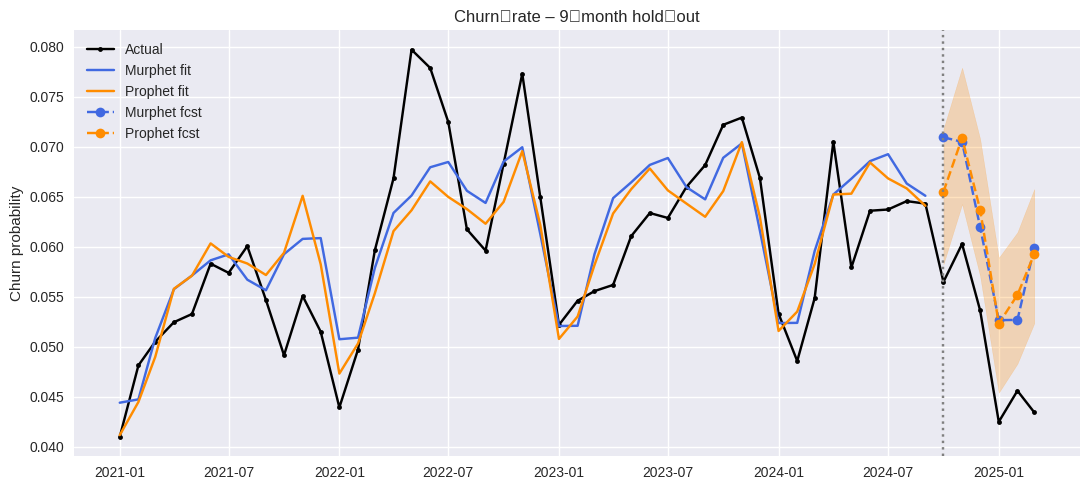

In [20]:
plt.style.use("seaborn-v0_8")

fig, ax = plt.subplots(figsize=(11, 5))
ax.plot(df["ds"], df["y"], "k.-", label="Actual")
ax.plot(train_ho["ds"], mur_fit.predict(train_ho["t"]),
        color="royalblue", label="Murphet fit")
ax.plot(train_ho["ds"], prop_fit.predict(train_ho[["ds"]])["yhat"],
        color="darkorange", label="Prophet fit")
ax.plot(test_ho["ds"], mur_pred, "o--", color="royalblue", label="Murphet fcst")
ax.plot(test_ho["ds"], prop_pred, "o--", color="darkorange", label="Prophet fcst")
ax.fill_between(test_ho["ds"], prop_low, prop_upp,
                 color="darkorange", alpha=0.25)
ax.axvline(test_ho["ds"].iloc[0], ls="dotted", color="gray")
ax.set_title("Churn‑rate – 9‑month hold‑out")
ax.set_ylabel("Churn probability")
ax.legend()
plt.tight_layout()
plt.show()
